In [1]:
import os
import glob
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
import sklearn as sklearn
import random

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#loading datasets
class NpyImageDataset(Dataset):
    """
    General dataset for loading .npy image files from a directory structure.
    Assumes that each class has its own subdirectory.
    """
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (str): Root directory containing subdirectories for each class.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # List all subdirectories (each is a class)
        class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
        # Create a mapping from class name to integer index
        self.class_to_idx = {class_name: i for i, class_name in enumerate(sorted(class_dirs))}
        
        # Collect all .npy files and assign labels based on folder
        for class_name in class_dirs:
            class_path = os.path.join(data_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            for file_path in glob.glob(os.path.join(class_path, '*.npy')):
                self.image_paths.append(file_path)
                self.labels.append(class_idx)
                
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image from .npy file
        image = np.load(self.image_paths[idx])
        label = self.labels[idx]
        image = torch.from_numpy(image).float()
        # If image is 2D (H x W), add a channel dimension.
        if image.dim() == 2:
            image = image.unsqueeze(0)
        if self.transform:
            image = self.transform(image)
        return image, label

class FilteredNpyImageDataset(Dataset):
    """
    Dataset that filters the samples from NpyImageDataset to only include one target class.
    This is used for pretraining the MAE on the 'no_sub' samples.
    """
    def __init__(self, data_dir, target_class, transform=None):
        base_dataset = NpyImageDataset(data_dir, transform=transform)
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = base_dataset.class_to_idx
        target_idx = self.class_to_idx[target_class]
        # Filter for only those samples whose label matches target_idx
        for path, label in zip(base_dataset.image_paths, base_dataset.labels):
            if label == target_idx:
                self.image_paths.append(path)
                self.labels.append(label)
                
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        label = self.labels[idx]
        image = torch.from_numpy(image).float()
        if image.dim() == 2:
            image = image.unsqueeze(0)
        if self.transform:
            image = self.transform(image)
        return image, label

class NpySuperResolutionDataset(Dataset):
    """
    Dataset for the super-resolution task.
    Expects that low-resolution (LR) and high-resolution (HR) .npy images are stored
    in separate directories but with matching filenames.
    """
    def __init__(self, lr_dir, hr_dir, transform_lr=None, transform_hr=None):
        self.lr_paths = sorted(glob.glob(os.path.join(lr_dir, '*.npy')))
        self.hr_paths = sorted(glob.glob(os.path.join(hr_dir, '*.npy')))
        assert len(self.lr_paths) == len(self.hr_paths), "Mismatch in number of LR and HR files"
        self.transform_lr = transform_lr
        self.transform_hr = transform_hr

    def __len__(self):
        return len(self.lr_paths)

    def __getitem__(self, idx):
        lr = np.load(self.lr_paths[idx])
        hr = np.load(self.hr_paths[idx])
        lr = torch.from_numpy(lr).float()
        hr = torch.from_numpy(hr).float()
        if lr.dim() == 2:
            lr = lr.unsqueeze(0)
        if hr.dim() == 2:
            hr = hr.unsqueeze(0)
        if self.transform_lr:
            lr = self.transform_lr(lr)
        if self.transform_hr:
            hr = self.transform_hr(hr)
        return lr, hr


In [3]:
def apply_patch_mask(img, mask_ratio=0.75, patch_size=16):
    """
    Applies a patch-level mask to an image.
    Divides the image (C, H, W) into patches of size patch_size x patch_size,
    randomly masks a fraction (mask_ratio) of the patches (sets them to 0),
    and returns both the masked image and the binary mask.
    """
    C, H, W = img.shape
    # Ensure H and W are divisible by patch_size
    assert H % patch_size == 0 and W % patch_size == 0, "Image dimensions must be divisible by patch_size"
    grid_h, grid_w = H // patch_size, W // patch_size
    # Create a mask for each patch (True if the patch is to be masked)
    patch_mask = (torch.rand(grid_h, grid_w) < mask_ratio)
    # Expand patch mask to pixel resolution
    mask = patch_mask.unsqueeze(0).repeat(C, 1, 1)
    mask = mask.repeat_interleave(patch_size, dim=1).repeat_interleave(patch_size, dim=2)
    # Create masked image: set masked pixels to 0
    img_masked = img.clone()
    img_masked[mask] = 0.0
    return img_masked, mask

In [4]:
class MAE(nn.Module):
    """
    A simple Masked Autoencoder model.
    The encoder is a small convolutional network and the decoder upsamples back to the original resolution.
    The model is trained to reconstruct only the masked portions of the input.
    """
    def __init__(self, in_channels=1, latent_dim=128):
        super(MAE, self).__init__()
        # Encoder: 3 conv layers with downsampling
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),   # -> (32, H/2, W/2)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),              # -> (64, H/4, W/4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, latent_dim, kernel_size=3, stride=2, padding=1),        # -> (latent_dim, H/8, W/8)
            nn.BatchNorm2d(latent_dim),
            nn.ReLU(),
        )
        # Decoder: 3 transposed conv layers for upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (64, H/4, W/4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=0),           # -> (32, H/2, W/2)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),    # -> (in_channels, H, W)
            nn.Sigmoid()  # To constrain outputs to [0, 1]
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon, latent

In [5]:
class ClassificationModel(nn.Module):
    """
    classification model with standard blocks.
    Uses dropout and batch normalization for better generalization.
    """
    def __init__(self, encoder, latent_dim=128, num_classes=3):
        super(ClassificationModel, self).__init__()
        #using the pretrained encoder
        self.encoder = encoder  
        
        #adding a few additional layers to adapt the encoder features
        self.adapt_layers = nn.Sequential(
            nn.Conv2d(latent_dim, latent_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(latent_dim),
            nn.ReLU(),
            nn.Conv2d(latent_dim, latent_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(latent_dim),
            nn.ReLU()
        )
        
        #global average pooling followed by classifier head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        #classifier head with dropout for regularization
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),  #dropout for regularization
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        features = self.encoder(x)
        features = self.adapt_layers(features)
        #global average pooling
        pooled = self.avgpool(features)
        #classification
        output = self.classifier(pooled)
        return output

In [6]:
class SuperResolutionModel(nn.Module):
    def __init__(self, encoder, latent_dim=128, in_channels=1, lr_size=(80, 80), hr_size=(150, 150)):
        super(SuperResolutionModel, self).__init__()
        self.encoder = encoder  #using pretrained encoder
        self.lr_size = lr_size
        self.hr_size = hr_size
        
        self.scale_factor = hr_size[0] / (lr_size[0] // 8)  #enoder downsamples by 8x
        
        #feature processing
        self.process_features = nn.Sequential(
            nn.Conv2d(latent_dim, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        #progressive upsampling to target size
        self.upsampler = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 2x upscale
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2x upscale
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 2x upscale
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        #final layer to adjust channel count and apply final adjustments
        self.final = nn.Sequential(
            nn.Conv2d(32, in_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        features = self.encoder(x)
        processed = self.process_features(features)
        
        
        #upsample progressively
        upsampled = self.upsampler(processed)


        out = self.final(upsampled)
        
        #resize to target HR size if needed
        if out.shape[2:] != self.hr_size:
            out = F.interpolate(out, size=self.hr_size, mode='bilinear', align_corners=False)
            
        return out

In [7]:
class MaskGenerator(nn.Module):
    """
    Adversarially-trained mask generator that predicts which patches contain higher information density.
    Uses the Gumbel-Softmax trick for differentiable mask sampling.
    """
    def __init__(self, in_channels=1, patch_size=16, hidden_dim=64):
        super(MaskGenerator, self).__init__()
        self.patch_size = patch_size
        
        # Downsampling network to process the image
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
        )
        
        # Final layer to predict patch importance scores
        self.score_predictor = nn.Conv2d(hidden_dim, 1, kernel_size=1)
        
        # Temperature parameter for Gumbel-Softmax
        self.temperature = nn.Parameter(torch.ones(1) * 1.0)

    def forward(self, x, mask_ratio=0.75, hard=True):
        """
        Args:
            x: Input image [B, C, H, W]
            mask_ratio: Ratio of patches to mask
            hard: Whether to use hard (True) or soft (False) sampling
            
        Returns:
            patch_mask: Binary mask at patch level [B, 1, H/patch_size, W/patch_size]
            pixel_mask: Binary mask at pixel level [B, C, H, W]
        """
        B, C, H, W = x.shape
        
        # Ensure dimensions are divisible by patch_size
        assert H % self.patch_size == 0 and W % self.patch_size == 0, "Image dimensions must be divisible by patch_size"
        
        # Number of patches in each dimension
        num_patches_h = H // self.patch_size
        num_patches_w = W // self.patch_size
        
        # Convert to patches
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(B, C, num_patches_h, num_patches_w, self.patch_size, self.patch_size)
        
        # Process the image to get patch importance scores
        features = self.encoder(x)
        
        # Resize features to match patch grid
        if features.shape[2:] != (num_patches_h, num_patches_w):
            features = F.adaptive_avg_pool2d(features, (num_patches_h, num_patches_w))
        
        # Generate importance scores for each patch
        patch_scores = self.score_predictor(features).squeeze(1)  # [B, H/patch_size, W/patch_size]
        
        # We want to mask patches with high scores (more informative)
        # Calculate how many patches to keep (unmask)
        num_keep = int((1 - mask_ratio) * num_patches_h * num_patches_w)
        
        if hard:
            # Gumbel-Softmax trick for differentiable sampling
            gumbel_noise = -torch.log(-torch.log(torch.rand_like(patch_scores) + 1e-10) + 1e-10)
            perturbed_scores = patch_scores + gumbel_noise * self.temperature
            
            # Find the top-k patches to keep (unmask)
            _, indices = torch.topk(perturbed_scores.reshape(B, -1), num_keep, dim=1)
            
            # Create binary mask (1 = keep, 0 = mask)
            patch_mask = torch.zeros_like(patch_scores.reshape(B, -1))
            patch_mask.scatter_(1, indices, 1.0)
            patch_mask = patch_mask.reshape(B, num_patches_h, num_patches_w)
        else:
            # Soft masking using sigmoid activation
            patch_mask = torch.sigmoid(patch_scores)
            # Adjust the threshold to match the desired mask ratio
            threshold = torch.topk(patch_mask.reshape(B, -1), num_keep, dim=1)[0][:, -1].view(B, 1, 1)
            patch_mask = (patch_mask >= threshold).float()
        
        # Expand patch mask to full resolution
        pixel_mask = patch_mask.unsqueeze(1)  # [B, 1, H/patch_size, W/patch_size]
        pixel_mask = pixel_mask.repeat_interleave(self.patch_size, dim=2).repeat_interleave(self.patch_size, dim=3)
        
        # Repeat across channels
        if pixel_mask.shape[1] != C:
            pixel_mask = pixel_mask.repeat(1, C, 1, 1)
            
        return 1 - patch_mask, 1 - pixel_mask  # Invert mask (1 = mask, 0 = keep)

class MAE_LearnMask(nn.Module):
    """
    AutoMAE: Masked Autoencoder with learnable masking strategy.
    Integrates a mask generator that learns to identify patches with higher information density.
    """
    def __init__(self, in_channels=1, latent_dim=128, patch_size=16):
        super(MAE_LearnMask, self).__init__()
        self.patch_size = patch_size
        
        # Mask generator network
        self.mask_generator = MaskGenerator(in_channels=in_channels, patch_size=patch_size)
        
        # Encoder (same as original MAE)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),   # -> (32, H/2, W/2)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),              # -> (64, H/4, W/4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, latent_dim, kernel_size=3, stride=2, padding=1),        # -> (latent_dim, H/8, W/8)
            nn.BatchNorm2d(latent_dim),
            nn.ReLU(),
        )
        
        # Decoder (same as original MAE)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (64, H/4, W/4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=0),           # -> (32, H/2, W/2)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),    # -> (in_channels, H, W)
            nn.Sigmoid()  # To constrain outputs to [0, 1]
        )
        
    def forward(self, x, mask_ratio=0.75, use_generated_mask=True):
        batch_size = x.shape[0]
        
        # Generate masks or use random masking
        if use_generated_mask:
            _, pixel_masks = self.mask_generator(x, mask_ratio=mask_ratio)
            masked_images = x * (1 - pixel_masks)  # Apply mask (0 = masked)
        else:
            # Fall back to random masking for comparison
            masked_images, pixel_masks = [], []
            for i in range(batch_size):
                img_masked, mask = apply_patch_mask(x[i], mask_ratio, self.patch_size)
                masked_images.append(img_masked)
                pixel_masks.append(mask)
            masked_images = torch.stack(masked_images)
            pixel_masks = torch.stack(pixel_masks)
        
        # Encode masked images
        latent = self.encoder(masked_images)
        
        # Decode to reconstruct full images
        recon = self.decoder(latent)
        
        return recon, latent, masked_images, pixel_masks

In [8]:
def train_mae_learn(model, dataloader, num_epochs=20, device='cuda', mask_ratio=0.75, patch_size=16, 
                   alpha=0.1, alternate_epochs=2):
    """
    Train AutoMAE with learnable masking strategy.
    
    Args:
        model: MAE_LearnMask model
        dataloader: DataLoader containing training images
        num_epochs: Number of training epochs
        device: Device to train on
        mask_ratio: Ratio of patches to mask
        patch_size: Size of each patch
        alpha: Weight for adversarial loss
        alternate_epochs: Number of epochs to alternate between training modes
        
    Returns:
        Trained model
    """
    model.train()
    model.to(device)
    
    # Two separate optimizers - one for reconstruction task and one for mask generator
    mae_optimizer = optim.Adam([
        {'params': model.encoder.parameters()},
        {'params': model.decoder.parameters()},
    ], lr=1e-3)
    
    mask_optimizer = optim.Adam(model.mask_generator.parameters(), lr=1e-4)
    
    # Loss functions
    mse_loss = nn.MSELoss(reduction='none')
    
    # Tracking metrics
    history = {'recon_loss': [], 'mask_loss': [], 'total_loss': []}
    
    for epoch in range(num_epochs):
        running_recon_loss = 0.0
        running_mask_loss = 0.0
        running_total_loss = 0.0
        
        # Decide whether to update mask generator this epoch
        update_mask_generator = (epoch % (2 * alternate_epochs)) < alternate_epochs
        
        for images, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - {'Mask Update' if update_mask_generator else 'MAE Update'}"):
            images = images.to(device)
            
            # Forward pass
            recon, _, masked_images, masks = model(images, mask_ratio=mask_ratio)
            
            # Resize reconstruction to match original image size if dimensions don't match
            if recon.shape != images.shape:
                recon = F.interpolate(recon, size=(images.shape[2], images.shape[3]), 
                                    mode='bilinear', align_corners=False)
            
            # Base reconstruction loss (pixel-wise MSE on masked regions)
            loss_map = mse_loss(recon, images)
            recon_loss = (loss_map * masks).sum() / masks.sum()
            
            # Adversarial loss for mask generator (maximize information gain)
            # We measure this as the reconstruction difficulty on masked regions
            mask_loss = -recon_loss * alpha
            
            # Combined loss depends on current training mode
            if update_mask_generator:
                total_loss = mask_loss
                mae_optimizer.zero_grad()
                mask_optimizer.zero_grad()
                total_loss.backward()
                mask_optimizer.step()
            else:
                total_loss = recon_loss
                mae_optimizer.zero_grad()
                mask_optimizer.zero_grad()
                total_loss.backward()
                mae_optimizer.step()
            
            # Track losses
            running_recon_loss += recon_loss.item() * images.size(0)
            running_mask_loss += mask_loss.item() * images.size(0)
            running_total_loss += total_loss.item() * images.size(0)
        
        # Compute epoch losses
        epoch_recon_loss = running_recon_loss / len(dataloader.dataset)
        epoch_mask_loss = running_mask_loss / len(dataloader.dataset)
        epoch_total_loss = running_total_loss / len(dataloader.dataset)
        
        # Update history
        history['recon_loss'].append(epoch_recon_loss)
        history['mask_loss'].append(epoch_mask_loss)
        history['total_loss'].append(epoch_total_loss)
        
        print(f"[AutoMAE] Epoch [{epoch+1}/{num_epochs}], "
              f"Recon Loss: {epoch_recon_loss:.6f}, Mask Loss: {epoch_mask_loss:.6f}, "
              f"Total Loss: {epoch_total_loss:.6f}, "
              f"Mode: {'Mask Update' if update_mask_generator else 'MAE Update'}")
        
    # Visualize the results and mask examples
    visualize_automae_results(model, dataloader, device, mask_ratio)
    
    # Plot training history
    plt.figure(figsize=(10, 4))
    plt.plot(history['recon_loss'], label='Reconstruction Loss')
    plt.plot([-l for l in history['mask_loss']], label='Mask Generator Loss (negated)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('AutoMAE Training History')
    plt.savefig('automae_training_history.png')
    plt.show()
    
    return model

def visualize_automae_results(model, dataloader, device, mask_ratio=0.75):
    """Visualize AutoMAE results with both learned and random masks"""
    model.eval()
    with torch.no_grad():
        for images, _ in dataloader:
            # Select 5 random images from the batch
            indices = random.sample(range(images.shape[0]), 5)
            originals = [images[i] for i in indices]
            images = images.to(device)
            
            # Get reconstructions with learned masks
            recon_learned, _, masked_learned, _ = model(images[indices], mask_ratio=mask_ratio)
            
            # Get reconstructions with random masks
            recon_random, _, masked_random, _ = model(images[indices], mask_ratio=mask_ratio, use_generated_mask=False)
            
            # Display results
            fig, axes = plt.subplots(5, 5, figsize=(15, 15))
            for i in range(5):
                # Original image
                axes[i, 0].imshow(originals[i].squeeze().cpu(), cmap='gray')
                axes[i, 0].set_title("Original")
                axes[i, 0].axis('off')
                
                # Learned mask
                axes[i, 1].imshow(masked_learned[i].squeeze().cpu(), cmap='gray')
                axes[i, 1].set_title("Learned Mask")
                axes[i, 1].axis('off')
                
                # Learned mask reconstruction
                axes[i, 2].imshow(recon_learned[i].squeeze().cpu(), cmap='gray')
                axes[i, 2].set_title("Recon (Learned)")
                axes[i, 2].axis('off')
                
                # Random mask
                axes[i, 3].imshow(masked_random[i].squeeze().cpu(), cmap='gray')
                axes[i, 3].set_title("Random Mask")
                axes[i, 3].axis('off')
                
                # Random mask reconstruction
                axes[i, 4].imshow(recon_random[i].squeeze().cpu(), cmap='gray')
                axes[i, 4].set_title("Recon (Random)")
                axes[i, 4].axis('off')
                
            plt.tight_layout()
            plt.savefig('automae_visualization.png')
            plt.show()
            break

In [9]:
def train_mae(model, dataloader, num_epochs=20, device='cuda', mask_ratio=0.75, patch_size=16):
    """
    Train the MAE model using masked reconstruction loss (MSE computed only on masked pixels).
    """
    model.train()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    # We use MSELoss but will manually weight the loss on masked regions.
    mse_loss = nn.MSELoss(reduction='none')
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            # Apply patch masking to each image in the batch
            masked_images = []
            masks = []
            for img in images:
                img_masked, mask = apply_patch_mask(img, mask_ratio, patch_size)
                masked_images.append(img_masked)
                masks.append(mask)
            masked_images = torch.stack(masked_images).to(device)
            masks = torch.stack(masks).to(device)
            
            optimizer.zero_grad()
            recon, _ = model(masked_images)
            # Resize reconstruction to match original image size if dimensions don't match
            if recon.shape != images.shape:
                recon = F.interpolate(recon, size=(images.shape[2], images.shape[3]), mode='bilinear', align_corners=False)
            # Compute loss only on masked pixels
            loss_map = mse_loss(recon, images)
            loss = (loss_map * masks).sum() / masks.sum()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"[MAE Pretraining] Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")
        
    # Visualize 5 random examples: original, masked, and reconstructed images
    model.eval()
    with torch.no_grad():
        for images, _ in dataloader:
            # Select 5 random images from the batch
            indices = random.sample(range(images.shape[0]), 5)
            originals, masked, reconstructions = [], [], []
            for i in indices:
                img = images[i].to(device)
                img_masked, _ = apply_patch_mask(img, mask_ratio, patch_size)
                output, _ = model(img_masked.unsqueeze(0))
                # Resize if necessary to match original image dimensions
                if output.shape != img.unsqueeze(0).shape:
                    output = F.interpolate(output, size=(img.shape[1], img.shape[2]), mode='bilinear', align_corners=False)
                originals.append(img.cpu())
                masked.append(img_masked.cpu())
                reconstructions.append(output.squeeze(0).cpu())
            break

    fig, axes = plt.subplots(5, 3, figsize=(12, 20))
    for i in range(5):
        axes[i, 0].imshow(originals[i].squeeze(), cmap='gray')
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')
        axes[i, 1].imshow(masked[i].squeeze(), cmap='gray')
        axes[i, 1].set_title("Masked")
        axes[i, 1].axis('off')
        axes[i, 2].imshow(reconstructions[i].squeeze(), cmap='gray')
        axes[i, 2].set_title("Reconstructed")
        axes[i, 2].axis('off')
    plt.tight_layout()
    plt.show()
    # save image
    plt.savefig('reconstruction_results.png')
    return model


In [10]:
def train_classifier(model, train_loader, val_loader, num_epochs=10, device='cuda'):
    """
    Improved training function for the classifier with learning rate scheduling,
    early stopping, and model checkpointing.
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    # Use SGD with momentum instead of Adam for better convergence
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    
    # Learning rate scheduler - reduce LR when plateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
    
    best_auc = 0.0
    best_model_state = None
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            running_loss += loss.item() * images.size(0)
            
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100.0 * correct / total
        
        # Validation phase
        model.eval()
        all_labels = []
        all_probs = []
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                
                # Calculate accuracy
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                
                # For AUC calculation
                probs = torch.softmax(outputs, dim=1)
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100.0 * val_correct / val_total
        
        # Convert ground truth to one-hot encoding for roc_auc_score
        num_classes = len(set(all_labels))
        one_hot_labels = np.eye(num_classes)[np.array(all_labels)]
        try:
            auc_score = roc_auc_score(one_hot_labels, np.array(all_probs), average='macro')
        except Exception as e:
            print(f"Warning: Error calculating AUC: {str(e)}")
            auc_score = 0.0
        
        # Print metrics
        print(f"[Classifier] Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
              f"ROC AUC: {auc_score:.4f}")
        
        # Update learning rate based on AUC
        scheduler.step(auc_score)
        
        # Check if this is the best model (based on AUC)
        if auc_score > best_auc:
            best_auc = auc_score
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load the best model weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with AUC: {best_auc:.4f}")
    
    return model

In [11]:
def visualize_classifier_roc_auc(model, test_loader, num_classes=3, device='cuda'):
    """
    Visualizes ROC curves and calculates AUC for each class in a classifier model.
    
    Args:
        model: The trained classifier model
        test_loader: DataLoader containing test/validation data
        num_classes: Number of classes in the classification task
        device: Device to run inference on
    """
    model.eval()
    
    # Collect all predictions and true labels
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Generating predictions"):
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())
    
    # Concatenate batches
    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # One-hot encode true labels for ROC calculation
    true_labels_one_hot = np.zeros((all_labels.size, num_classes))
    for i in range(all_labels.size):
        true_labels_one_hot[i, all_labels[i]] = 1
    
    # Calculate ROC curves and AUC for each class
    plt.figure(figsize=(10, 8))
    
    class_auc_scores = []
    
    # For micro-average ROC curve
    all_probs_flat = all_probs.ravel()
    all_labels_flat = true_labels_one_hot.ravel()
    
    for i in range(num_classes):
        # Calculate ROC curve for this class
        fpr, tpr, _ = sklearn.metrics.roc_curve(true_labels_one_hot[:, i], all_probs[:, i])
        
        # Calculate AUC
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        class_auc_scores.append(roc_auc)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})')
    
    # Calculate and plot micro-average ROC curve
    fpr_micro, tpr_micro, _ = sklearn.metrics.roc_curve(all_labels_flat, all_probs_flat)
    roc_auc_micro = sklearn.metrics.auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, lw=2, linestyle='--',
             label=f'Micro-average (AUC = {roc_auc_micro:.3f})')
    
    # Calculate and report macro-average AUC
    macro_roc_auc = np.mean(class_auc_scores)
    
    # Plot diagonal line for random classifier
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multi-Class Classification')
    plt.legend(loc="lower right")
    
    # Add text with macro-average AUC
    plt.text(0.7, 0.3, f'Macro-average AUC: {macro_roc_auc:.3f}', 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('classifier_roc_auc.png', dpi=300)
    plt.show()
    
    # Print AUC scores in table format
    print("\nAUC Scores:")
    print("-" * 30)
    print(f"{'Class':<10} | {'AUC Score':<10}")
    print("-" * 30)
    for i, score in enumerate(class_auc_scores):
        print(f"{i:<10} | {score:.4f}")
    print("-" * 30)
    print(f"{'Micro-avg':<10} | {roc_auc_micro:.4f}")
    print(f"{'Macro-avg':<10} | {macro_roc_auc:.4f}")
    
    return class_auc_scores, roc_auc_micro, macro_roc_auc

In [12]:
def train_super_resolution(model, dataloader, num_epochs=10, device='cuda'):
    """
    Improved training function for super-resolution with L1 loss component
    and proper handling of output size.
    """
    model.to(device)
    # Combine MSE and L1 loss for better results
    mse_criterion = nn.MSELoss()
    l1_criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=2e-4, betas=(0.9, 0.999))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    
    for epoch in range(num_epochs):
        model.train()
        running_mse_loss = 0.0
        running_l1_loss = 0.0
        running_total_loss = 0.0
        
        for lr_imgs, hr_imgs in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            
            optimizer.zero_grad()
            outputs = model(lr_imgs)
            
            # Ensure output size matches target size
            if outputs.shape != hr_imgs.shape:
                outputs = F.interpolate(outputs, size=(hr_imgs.shape[2], hr_imgs.shape[3]), 
                                        mode='bilinear', align_corners=False)
                
            # Calculate losses
            mse_loss = mse_criterion(outputs, hr_imgs)
            l1_loss = l1_criterion(outputs, hr_imgs)
            # Combined loss (MSE with L1 regularization)
            loss = mse_loss + 0.5 * l1_loss
            
            loss.backward()
            optimizer.step()
            
            # Track metrics
            running_mse_loss += mse_loss.item() * lr_imgs.size(0)
            running_l1_loss += l1_loss.item() * lr_imgs.size(0)
            running_total_loss += loss.item() * lr_imgs.size(0)
            
        # Compute epoch losses
        epoch_mse_loss = running_mse_loss / len(dataloader.dataset)
        epoch_l1_loss = running_l1_loss / len(dataloader.dataset)
        epoch_total_loss = running_total_loss / len(dataloader.dataset)
        
        # PSNR calculation (assuming images normalized in [0,1])
        psnr = 10 * math.log10(1.0 / (epoch_mse_loss + 1e-8))
        
        # Update learning rate
        scheduler.step()
        
        print(f"[Super-Resolution] Epoch [{epoch+1}/{num_epochs}], "
              f"MSE Loss: {epoch_mse_loss:.6f}, L1 Loss: {epoch_l1_loss:.6f}, "
              f"Total Loss: {epoch_total_loss:.6f}, PSNR: {psnr:.2f} dB")
    
    # Visualize a few examples
    model.eval()
    with torch.no_grad():
        for lr_imgs, hr_imgs in dataloader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            
            # Ensure correct size for visualization
            if sr_imgs.shape != hr_imgs.shape:
                sr_imgs = F.interpolate(sr_imgs, size=(hr_imgs.shape[2], hr_imgs.shape[3]), 
                                        mode='bilinear', align_corners=False)
            
            # Pick a few samples to visualize
            n_samples = min(3, lr_imgs.size(0))
            
            fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5*n_samples))
            for i in range(n_samples):
                # Low-resolution input
                axes[i, 0].imshow(lr_imgs[i].cpu().squeeze(0), cmap='gray')
                axes[i, 0].set_title("Low Resolution")
                axes[i, 0].axis('off')
                
                # Super-resolution output
                axes[i, 1].imshow(sr_imgs[i].cpu().squeeze(0), cmap='gray')
                axes[i, 1].set_title("Super Resolution")
                axes[i, 1].axis('off')
                
                # High-resolution ground truth
                axes[i, 2].imshow(hr_imgs[i].cpu().squeeze(0), cmap='gray')
                axes[i, 2].set_title("High Resolution")
                axes[i, 2].axis('off')
            
            plt.tight_layout()
            plt.show()
            plt.savefig('super_resolution_results.png')
            break
            
    return model

Using device: cuda
Starting MAE pretraining...


Epoch 1/50: 100%|██████████| 157/157 [00:14<00:00, 10.58it/s]


[MAE Pretraining] Epoch [1/50], Loss: 0.008865


Epoch 2/50: 100%|██████████| 157/157 [00:08<00:00, 17.65it/s]


[MAE Pretraining] Epoch [2/50], Loss: 0.001246


Epoch 3/50: 100%|██████████| 157/157 [00:09<00:00, 17.27it/s]


[MAE Pretraining] Epoch [3/50], Loss: 0.001028


Epoch 4/50: 100%|██████████| 157/157 [00:09<00:00, 17.21it/s]


[MAE Pretraining] Epoch [4/50], Loss: 0.000860


Epoch 5/50: 100%|██████████| 157/157 [00:09<00:00, 17.36it/s]


[MAE Pretraining] Epoch [5/50], Loss: 0.000792


Epoch 6/50: 100%|██████████| 157/157 [00:09<00:00, 17.38it/s]


[MAE Pretraining] Epoch [6/50], Loss: 0.000725


Epoch 7/50: 100%|██████████| 157/157 [00:09<00:00, 17.30it/s]


[MAE Pretraining] Epoch [7/50], Loss: 0.000670


Epoch 8/50: 100%|██████████| 157/157 [00:09<00:00, 17.28it/s]


[MAE Pretraining] Epoch [8/50], Loss: 0.000697


Epoch 9/50: 100%|██████████| 157/157 [00:09<00:00, 17.22it/s]


[MAE Pretraining] Epoch [9/50], Loss: 0.000627


Epoch 10/50: 100%|██████████| 157/157 [00:08<00:00, 17.47it/s]


[MAE Pretraining] Epoch [10/50], Loss: 0.000625


Epoch 11/50: 100%|██████████| 157/157 [00:09<00:00, 17.29it/s]


[MAE Pretraining] Epoch [11/50], Loss: 0.000603


Epoch 12/50: 100%|██████████| 157/157 [00:09<00:00, 17.39it/s]


[MAE Pretraining] Epoch [12/50], Loss: 0.000582


Epoch 13/50: 100%|██████████| 157/157 [00:08<00:00, 17.48it/s]


[MAE Pretraining] Epoch [13/50], Loss: 0.000581


Epoch 14/50: 100%|██████████| 157/157 [00:08<00:00, 17.49it/s]


[MAE Pretraining] Epoch [14/50], Loss: 0.000571


Epoch 15/50: 100%|██████████| 157/157 [00:09<00:00, 17.42it/s]


[MAE Pretraining] Epoch [15/50], Loss: 0.000575


Epoch 16/50: 100%|██████████| 157/157 [00:09<00:00, 17.33it/s]


[MAE Pretraining] Epoch [16/50], Loss: 0.000556


Epoch 17/50: 100%|██████████| 157/157 [00:09<00:00, 17.41it/s]


[MAE Pretraining] Epoch [17/50], Loss: 0.000564


Epoch 18/50: 100%|██████████| 157/157 [00:09<00:00, 17.18it/s]


[MAE Pretraining] Epoch [18/50], Loss: 0.000531


Epoch 19/50: 100%|██████████| 157/157 [00:09<00:00, 17.36it/s]


[MAE Pretraining] Epoch [19/50], Loss: 0.000538


Epoch 20/50: 100%|██████████| 157/157 [00:08<00:00, 17.50it/s]


[MAE Pretraining] Epoch [20/50], Loss: 0.000529


Epoch 21/50: 100%|██████████| 157/157 [00:08<00:00, 17.59it/s]


[MAE Pretraining] Epoch [21/50], Loss: 0.000513


Epoch 22/50: 100%|██████████| 157/157 [00:09<00:00, 17.25it/s]


[MAE Pretraining] Epoch [22/50], Loss: 0.000520


Epoch 23/50: 100%|██████████| 157/157 [00:08<00:00, 17.56it/s]


[MAE Pretraining] Epoch [23/50], Loss: 0.000531


Epoch 24/50: 100%|██████████| 157/157 [00:08<00:00, 17.54it/s]


[MAE Pretraining] Epoch [24/50], Loss: 0.000501


Epoch 25/50: 100%|██████████| 157/157 [00:09<00:00, 17.27it/s]


[MAE Pretraining] Epoch [25/50], Loss: 0.000505


Epoch 26/50: 100%|██████████| 157/157 [00:09<00:00, 17.29it/s]


[MAE Pretraining] Epoch [26/50], Loss: 0.000487


Epoch 27/50: 100%|██████████| 157/157 [00:09<00:00, 17.41it/s]


[MAE Pretraining] Epoch [27/50], Loss: 0.000522


Epoch 28/50: 100%|██████████| 157/157 [00:08<00:00, 17.72it/s]


[MAE Pretraining] Epoch [28/50], Loss: 0.000491


Epoch 29/50: 100%|██████████| 157/157 [00:09<00:00, 17.32it/s]


[MAE Pretraining] Epoch [29/50], Loss: 0.000487


Epoch 30/50: 100%|██████████| 157/157 [00:08<00:00, 17.46it/s]


[MAE Pretraining] Epoch [30/50], Loss: 0.000492


Epoch 31/50: 100%|██████████| 157/157 [00:08<00:00, 17.58it/s]


[MAE Pretraining] Epoch [31/50], Loss: 0.000489


Epoch 32/50: 100%|██████████| 157/157 [00:08<00:00, 17.52it/s]


[MAE Pretraining] Epoch [32/50], Loss: 0.000480


Epoch 33/50: 100%|██████████| 157/157 [00:09<00:00, 17.24it/s]


[MAE Pretraining] Epoch [33/50], Loss: 0.000473


Epoch 34/50: 100%|██████████| 157/157 [00:08<00:00, 17.61it/s]


[MAE Pretraining] Epoch [34/50], Loss: 0.000471


Epoch 35/50: 100%|██████████| 157/157 [00:09<00:00, 17.43it/s]


[MAE Pretraining] Epoch [35/50], Loss: 0.000459


Epoch 36/50: 100%|██████████| 157/157 [00:09<00:00, 17.20it/s]


[MAE Pretraining] Epoch [36/50], Loss: 0.000474


Epoch 37/50: 100%|██████████| 157/157 [00:09<00:00, 17.37it/s]


[MAE Pretraining] Epoch [37/50], Loss: 0.000472


Epoch 38/50: 100%|██████████| 157/157 [00:09<00:00, 17.32it/s]


[MAE Pretraining] Epoch [38/50], Loss: 0.000455


Epoch 39/50: 100%|██████████| 157/157 [00:09<00:00, 17.32it/s]


[MAE Pretraining] Epoch [39/50], Loss: 0.000475


Epoch 40/50: 100%|██████████| 157/157 [00:09<00:00, 17.29it/s]


[MAE Pretraining] Epoch [40/50], Loss: 0.000467


Epoch 41/50: 100%|██████████| 157/157 [00:09<00:00, 17.42it/s]


[MAE Pretraining] Epoch [41/50], Loss: 0.000467


Epoch 42/50: 100%|██████████| 157/157 [00:08<00:00, 17.46it/s]


[MAE Pretraining] Epoch [42/50], Loss: 0.000467


Epoch 43/50: 100%|██████████| 157/157 [00:09<00:00, 17.19it/s]


[MAE Pretraining] Epoch [43/50], Loss: 0.000445


Epoch 44/50: 100%|██████████| 157/157 [00:09<00:00, 17.31it/s]


[MAE Pretraining] Epoch [44/50], Loss: 0.000449


Epoch 45/50: 100%|██████████| 157/157 [00:09<00:00, 17.42it/s]


[MAE Pretraining] Epoch [45/50], Loss: 0.000456


Epoch 46/50: 100%|██████████| 157/157 [00:09<00:00, 17.34it/s]


[MAE Pretraining] Epoch [46/50], Loss: 0.000469


Epoch 47/50: 100%|██████████| 157/157 [00:09<00:00, 17.30it/s]


[MAE Pretraining] Epoch [47/50], Loss: 0.000454


Epoch 48/50: 100%|██████████| 157/157 [00:09<00:00, 17.28it/s]


[MAE Pretraining] Epoch [48/50], Loss: 0.000458


Epoch 49/50: 100%|██████████| 157/157 [00:09<00:00, 17.26it/s]


[MAE Pretraining] Epoch [49/50], Loss: 0.000460


Epoch 50/50: 100%|██████████| 157/157 [00:09<00:00, 17.04it/s]

[MAE Pretraining] Epoch [50/50], Loss: 0.000458


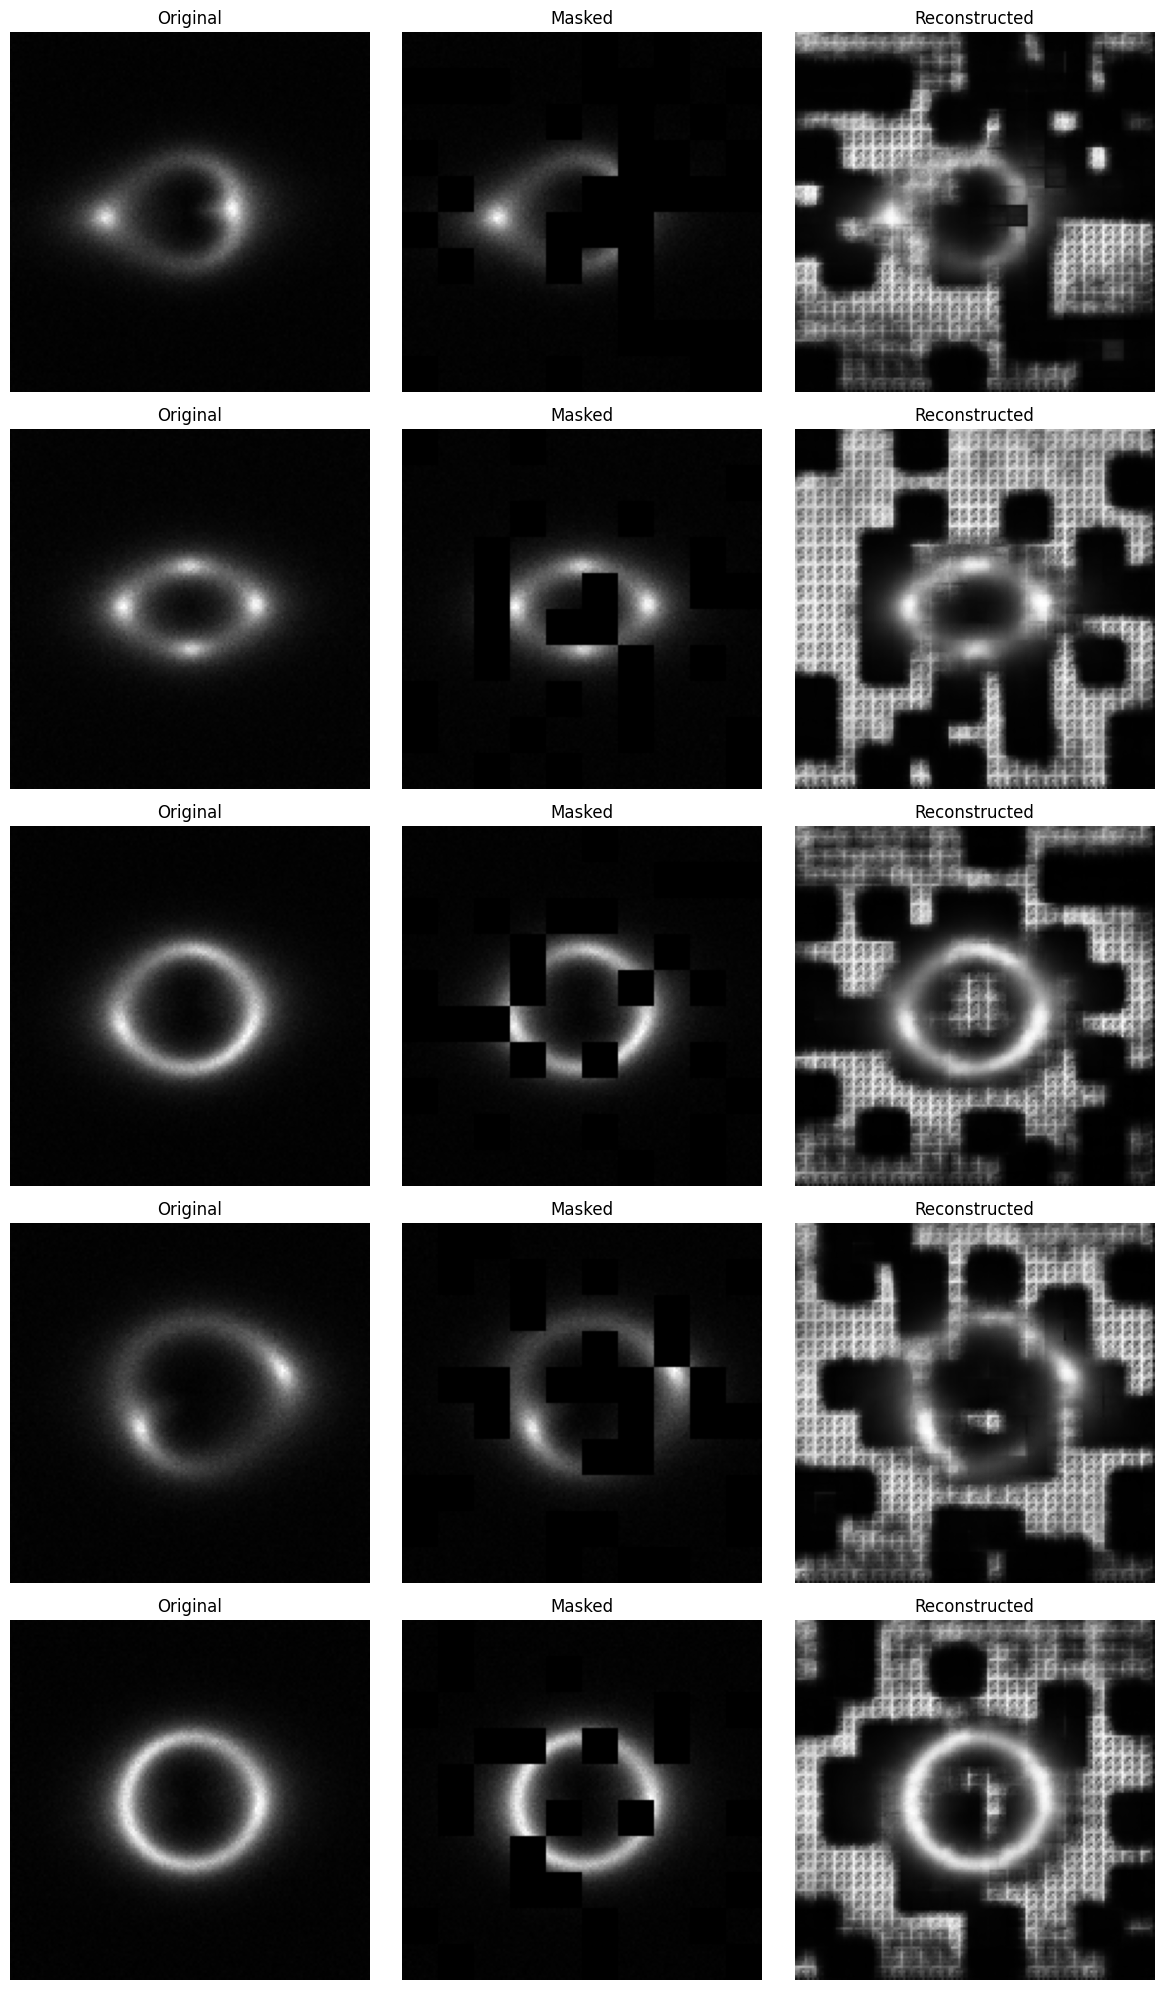

<Figure size 640x480 with 0 Axes>

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

#any necessary transforms (here we assume images are already normalized)
transform = None  

mae_data_dir = '/kaggle/input/deeplense-lensing-classes/dataset/train'  # Should contain subfolders including "no_sub"
target_class = 'no'  # Only use samples with no substructure for pretraining
mae_dataset = FilteredNpyImageDataset(mae_data_dir, target_class=target_class, transform=transform)
mae_loader = DataLoader(mae_dataset, batch_size=64, shuffle=True, num_workers=4)

# Initialize the MAE model (assuming images are single-channel)
mae_model = MAE(in_channels=1, latent_dim=256)
print("Starting MAE pretraining...")
mae_model = train_mae(mae_model, mae_loader, num_epochs=50, device=device, mask_ratio=0.30, patch_size=15)

# Get the pretrained encoder for later use
pretrained_encoder = mae_model.encoder




/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting classifier fine-tuning with frozen encoder...


Epoch 1/50 - Validation: 100%|██████████| 118/118 [00:11<00:00, 10.48it/s]


[Classifier] Epoch [1/50], Train Loss: 1.1109, Train Acc: 33.76%, Val Loss: 1.1082, Val Acc: 33.63%, ROC AUC: 0.5073


Epoch 2/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.39it/s]


[Classifier] Epoch [2/50], Train Loss: 1.1033, Train Acc: 34.13%, Val Loss: 1.0994, Val Acc: 35.13%, ROC AUC: 0.5286


Epoch 3/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 48.40it/s]


[Classifier] Epoch [3/50], Train Loss: 1.0949, Train Acc: 36.51%, Val Loss: 1.0978, Val Acc: 36.43%, ROC AUC: 0.5482


Epoch 4/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 48.25it/s]


[Classifier] Epoch [4/50], Train Loss: 1.0751, Train Acc: 40.33%, Val Loss: 1.0891, Val Acc: 37.96%, ROC AUC: 0.5966


Epoch 5/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 48.30it/s]


[Classifier] Epoch [5/50], Train Loss: 1.0516, Train Acc: 43.24%, Val Loss: 1.1905, Val Acc: 33.99%, ROC AUC: 0.5813


Epoch 6/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 46.48it/s]


[Classifier] Epoch [6/50], Train Loss: 1.0248, Train Acc: 45.62%, Val Loss: 1.1135, Val Acc: 40.11%, ROC AUC: 0.6178


Epoch 7/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 46.81it/s]


[Classifier] Epoch [7/50], Train Loss: 1.0007, Train Acc: 47.72%, Val Loss: 1.4819, Val Acc: 33.89%, ROC AUC: 0.6329


Epoch 8/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 46.86it/s]


[Classifier] Epoch [8/50], Train Loss: 0.9831, Train Acc: 48.76%, Val Loss: 1.4115, Val Acc: 33.77%, ROC AUC: 0.5749


Epoch 9/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 47.77it/s]


[Classifier] Epoch [9/50], Train Loss: 0.9588, Train Acc: 50.57%, Val Loss: 2.7616, Val Acc: 33.33%, ROC AUC: 0.5976


Epoch 10/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 49.71it/s]


[Classifier] Epoch [10/50], Train Loss: 0.9444, Train Acc: 51.88%, Val Loss: 1.3011, Val Acc: 36.96%, ROC AUC: 0.6442


Epoch 11/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 46.72it/s]


[Classifier] Epoch [11/50], Train Loss: 0.9329, Train Acc: 52.66%, Val Loss: 1.5077, Val Acc: 34.13%, ROC AUC: 0.6247


Epoch 12/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 46.01it/s]


[Classifier] Epoch [12/50], Train Loss: 0.9190, Train Acc: 53.34%, Val Loss: 1.0792, Val Acc: 44.43%, ROC AUC: 0.6664


Epoch 13/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 47.09it/s]


[Classifier] Epoch [13/50], Train Loss: 0.9030, Train Acc: 54.63%, Val Loss: 3.5725, Val Acc: 33.33%, ROC AUC: 0.6309


Epoch 14/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 47.05it/s]


[Classifier] Epoch [14/50], Train Loss: 0.8912, Train Acc: 55.57%, Val Loss: 3.1254, Val Acc: 33.33%, ROC AUC: 0.6577


Epoch 15/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 45.11it/s]


[Classifier] Epoch [15/50], Train Loss: 0.8781, Train Acc: 56.33%, Val Loss: 2.0188, Val Acc: 33.87%, ROC AUC: 0.6854


Epoch 16/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 47.91it/s]


[Classifier] Epoch [16/50], Train Loss: 0.8616, Train Acc: 57.39%, Val Loss: 1.3548, Val Acc: 43.52%, ROC AUC: 0.6787


Epoch 17/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 46.36it/s]


[Classifier] Epoch [17/50], Train Loss: 0.8445, Train Acc: 58.68%, Val Loss: 1.8983, Val Acc: 34.93%, ROC AUC: 0.6492


Epoch 18/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 47.83it/s]


[Classifier] Epoch [18/50], Train Loss: 0.8330, Train Acc: 59.39%, Val Loss: 1.1411, Val Acc: 49.84%, ROC AUC: 0.7006


Epoch 19/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 49.45it/s]


[Classifier] Epoch [19/50], Train Loss: 0.8151, Train Acc: 60.22%, Val Loss: 0.9826, Val Acc: 51.71%, ROC AUC: 0.7436


Epoch 20/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 49.35it/s]


[Classifier] Epoch [20/50], Train Loss: 0.8030, Train Acc: 61.53%, Val Loss: 0.9655, Val Acc: 53.32%, ROC AUC: 0.7599


Epoch 21/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 48.03it/s]


[Classifier] Epoch [21/50], Train Loss: 0.7897, Train Acc: 62.41%, Val Loss: 1.9847, Val Acc: 36.28%, ROC AUC: 0.6673


Epoch 22/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 45.87it/s]


[Classifier] Epoch [22/50], Train Loss: 0.7764, Train Acc: 63.17%, Val Loss: 0.8927, Val Acc: 56.97%, ROC AUC: 0.7616


Epoch 23/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 48.60it/s]


[Classifier] Epoch [23/50], Train Loss: 0.7584, Train Acc: 64.24%, Val Loss: 1.0719, Val Acc: 50.27%, ROC AUC: 0.7645


Epoch 24/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.15it/s]


[Classifier] Epoch [24/50], Train Loss: 0.7498, Train Acc: 65.06%, Val Loss: 1.0780, Val Acc: 49.93%, ROC AUC: 0.7486


Epoch 25/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 49.46it/s]


[Classifier] Epoch [25/50], Train Loss: 0.7328, Train Acc: 65.96%, Val Loss: 1.4985, Val Acc: 43.33%, ROC AUC: 0.7120


Epoch 26/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 48.40it/s]


[Classifier] Epoch [26/50], Train Loss: 0.7192, Train Acc: 66.86%, Val Loss: 1.2173, Val Acc: 50.20%, ROC AUC: 0.7397


Epoch 27/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 47.31it/s]


[Classifier] Epoch [27/50], Train Loss: 0.7034, Train Acc: 67.75%, Val Loss: 1.6886, Val Acc: 43.52%, ROC AUC: 0.6848


Epoch 28/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 45.35it/s]


[Classifier] Epoch [28/50], Train Loss: 0.6245, Train Acc: 71.85%, Val Loss: 1.8388, Val Acc: 47.16%, ROC AUC: 0.7429
Early stopping triggered after 28 epochs
Loaded best model with AUC: 0.7645


Generating predictions: 100%|██████████| 118/118 [00:02<00:00, 48.69it/s]


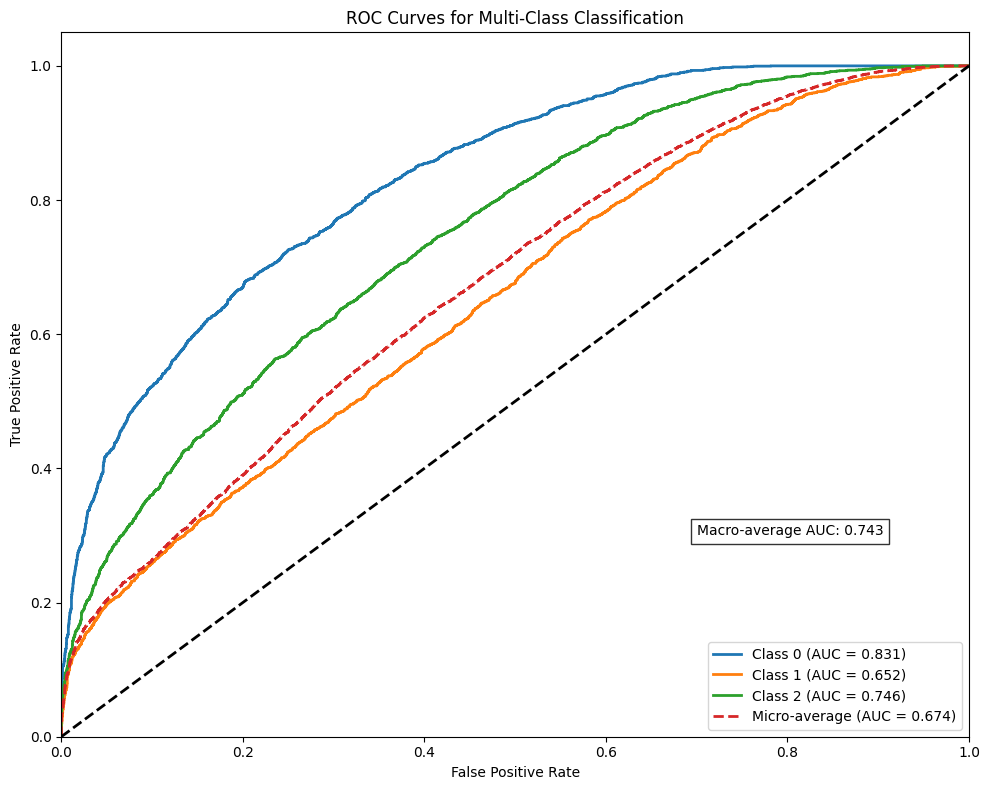


AUC Scores:
------------------------------
Class      | AUC Score 
------------------------------
0          | 0.8311
1          | 0.6515
2          | 0.7460
------------------------------
Micro-avg  | 0.6735
Macro-avg  | 0.7429
[0.83114084, 0.65154888, 0.74604216] 0.6735448622222222 0.7429106266666666


In [14]:

# 6A task

# Full dataset paths for training and validation
train_dir = '/kaggle/input/deeplense-lensing-classes/dataset/train'
val_dir   = '/kaggle/input/deeplense-lensing-classes/dataset/val'
dataset_train = NpyImageDataset(train_dir, transform=transform)
dataset_val   = NpyImageDataset(val_dir, transform=transform)
train_loader_cls = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=4)
val_loader_cls   = DataLoader(dataset_val, batch_size=64, shuffle=False, num_workers=4)

# Build improved classification model using the pretrained encoder
classifier_model = ClassificationModel(encoder=pretrained_encoder, latent_dim=256, num_classes=3)

# Freeze the encoder for a few epochs to allow the new layers to adapt
for param in classifier_model.encoder.parameters():
    param.requires_grad = False

print("Starting classifier fine-tuning with frozen encoder...")
classifier_model = train_classifier(classifier_model, train_loader_cls, val_loader_cls, num_epochs=50, device=device)


class_auc_scores, micro_auc, macro_auc = visualize_classifier_roc_auc(
    classifier_model, 
    val_loader_cls,
    num_classes=3, 
    device=device
)

print(class_auc_scores, micro_auc, macro_auc)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fine-tuning the entire model...


Epoch 1/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 49.83it/s]


[Classifier] Epoch [1/50], Train Loss: 0.8672, Train Acc: 59.27%, Val Loss: 5.0361, Val Acc: 33.33%, ROC AUC: 0.6532


Epoch 2/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 46.70it/s]


[Classifier] Epoch [2/50], Train Loss: 0.7345, Train Acc: 66.52%, Val Loss: 3.8010, Val Acc: 35.03%, ROC AUC: 0.6472


Epoch 3/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.98it/s]


[Classifier] Epoch [3/50], Train Loss: 0.6704, Train Acc: 69.92%, Val Loss: 0.9900, Val Acc: 56.73%, ROC AUC: 0.8004


Epoch 4/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 52.06it/s]


[Classifier] Epoch [4/50], Train Loss: 0.6256, Train Acc: 72.33%, Val Loss: 2.3443, Val Acc: 44.57%, ROC AUC: 0.7996


Epoch 5/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.27it/s]


[Classifier] Epoch [5/50], Train Loss: 0.5822, Train Acc: 74.85%, Val Loss: 2.7480, Val Acc: 35.35%, ROC AUC: 0.7347


Epoch 6/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.93it/s]


[Classifier] Epoch [6/50], Train Loss: 0.5455, Train Acc: 76.58%, Val Loss: 1.5303, Val Acc: 54.75%, ROC AUC: 0.8120


Epoch 7/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.39it/s]


[Classifier] Epoch [7/50], Train Loss: 0.5064, Train Acc: 78.86%, Val Loss: 0.8779, Val Acc: 62.24%, ROC AUC: 0.8627


Epoch 8/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.73it/s]


[Classifier] Epoch [8/50], Train Loss: 0.4794, Train Acc: 80.26%, Val Loss: 1.1120, Val Acc: 61.52%, ROC AUC: 0.8605


Epoch 9/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.76it/s]


[Classifier] Epoch [9/50], Train Loss: 0.4426, Train Acc: 81.81%, Val Loss: 1.0403, Val Acc: 65.11%, ROC AUC: 0.8571


Epoch 10/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 49.97it/s]


[Classifier] Epoch [10/50], Train Loss: 0.4255, Train Acc: 82.77%, Val Loss: 1.3742, Val Acc: 45.64%, ROC AUC: 0.8316


Epoch 11/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 52.80it/s]


[Classifier] Epoch [11/50], Train Loss: 0.3958, Train Acc: 83.94%, Val Loss: 0.7598, Val Acc: 70.61%, ROC AUC: 0.8934


Epoch 12/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 52.84it/s]


[Classifier] Epoch [12/50], Train Loss: 0.3704, Train Acc: 85.34%, Val Loss: 1.4850, Val Acc: 60.37%, ROC AUC: 0.8667


Epoch 13/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.26it/s]


[Classifier] Epoch [13/50], Train Loss: 0.3642, Train Acc: 85.59%, Val Loss: 0.8273, Val Acc: 71.73%, ROC AUC: 0.9136


Epoch 14/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.34it/s]


[Classifier] Epoch [14/50], Train Loss: 0.3374, Train Acc: 86.75%, Val Loss: 1.6345, Val Acc: 52.79%, ROC AUC: 0.8764


Epoch 15/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.61it/s]


[Classifier] Epoch [15/50], Train Loss: 0.3221, Train Acc: 87.30%, Val Loss: 0.8304, Val Acc: 73.33%, ROC AUC: 0.9215


Epoch 16/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 52.86it/s]


[Classifier] Epoch [16/50], Train Loss: 0.2975, Train Acc: 88.40%, Val Loss: 1.9789, Val Acc: 41.80%, ROC AUC: 0.8710


Epoch 17/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.31it/s]


[Classifier] Epoch [17/50], Train Loss: 0.3005, Train Acc: 88.49%, Val Loss: 0.7051, Val Acc: 76.32%, ROC AUC: 0.9366


Epoch 18/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.86it/s]


[Classifier] Epoch [18/50], Train Loss: 0.2848, Train Acc: 89.07%, Val Loss: 0.9147, Val Acc: 71.84%, ROC AUC: 0.9080


Epoch 19/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 53.81it/s]


[Classifier] Epoch [19/50], Train Loss: 0.2662, Train Acc: 89.81%, Val Loss: 0.4411, Val Acc: 83.84%, ROC AUC: 0.9621


Epoch 20/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.94it/s]


[Classifier] Epoch [20/50], Train Loss: 0.2593, Train Acc: 90.02%, Val Loss: 0.6372, Val Acc: 77.77%, ROC AUC: 0.9438


Epoch 21/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 49.87it/s]


[Classifier] Epoch [21/50], Train Loss: 0.2455, Train Acc: 90.49%, Val Loss: 0.5040, Val Acc: 80.13%, ROC AUC: 0.9466


Epoch 22/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 53.23it/s]


[Classifier] Epoch [22/50], Train Loss: 0.2483, Train Acc: 90.51%, Val Loss: 1.0260, Val Acc: 59.39%, ROC AUC: 0.9142


Epoch 23/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.93it/s]


[Classifier] Epoch [23/50], Train Loss: 0.2349, Train Acc: 91.21%, Val Loss: 0.6468, Val Acc: 77.87%, ROC AUC: 0.9345


Epoch 24/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.28it/s]


[Classifier] Epoch [24/50], Train Loss: 0.1437, Train Acc: 94.75%, Val Loss: 0.5075, Val Acc: 83.43%, ROC AUC: 0.9656


Epoch 25/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 47.08it/s]


[Classifier] Epoch [25/50], Train Loss: 0.1185, Train Acc: 95.77%, Val Loss: 0.4292, Val Acc: 85.20%, ROC AUC: 0.9632


Epoch 26/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 53.69it/s]


[Classifier] Epoch [26/50], Train Loss: 0.1107, Train Acc: 95.95%, Val Loss: 4.6161, Val Acc: 41.36%, ROC AUC: 0.8779


Epoch 27/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 52.75it/s]


[Classifier] Epoch [27/50], Train Loss: 0.1087, Train Acc: 95.97%, Val Loss: 0.4271, Val Acc: 85.84%, ROC AUC: 0.9651


Epoch 28/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 52.10it/s]


[Classifier] Epoch [28/50], Train Loss: 0.1016, Train Acc: 96.35%, Val Loss: 2.3699, Val Acc: 52.05%, ROC AUC: 0.8746


Epoch 29/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.27it/s]


[Classifier] Epoch [29/50], Train Loss: 0.0568, Train Acc: 98.11%, Val Loss: 0.3986, Val Acc: 87.19%, ROC AUC: 0.9675


Epoch 30/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.88it/s]


[Classifier] Epoch [30/50], Train Loss: 0.0363, Train Acc: 98.86%, Val Loss: 0.5068, Val Acc: 87.20%, ROC AUC: 0.9689


Epoch 31/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 53.32it/s]


[Classifier] Epoch [31/50], Train Loss: 0.0280, Train Acc: 99.22%, Val Loss: 0.4135, Val Acc: 88.49%, ROC AUC: 0.9705


Epoch 32/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.56it/s]


[Classifier] Epoch [32/50], Train Loss: 0.0236, Train Acc: 99.32%, Val Loss: 0.4742, Val Acc: 87.69%, ROC AUC: 0.9672


Epoch 33/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 48.83it/s]


[Classifier] Epoch [33/50], Train Loss: 0.0222, Train Acc: 99.33%, Val Loss: 0.4561, Val Acc: 88.40%, ROC AUC: 0.9699


Epoch 34/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.77it/s]


[Classifier] Epoch [34/50], Train Loss: 0.0215, Train Acc: 99.37%, Val Loss: 0.4703, Val Acc: 87.20%, ROC AUC: 0.9670


Epoch 35/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 48.38it/s]


[Classifier] Epoch [35/50], Train Loss: 0.0232, Train Acc: 99.24%, Val Loss: 0.5153, Val Acc: 87.52%, ROC AUC: 0.9662


Epoch 36/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.92it/s]


[Classifier] Epoch [36/50], Train Loss: 0.0142, Train Acc: 99.66%, Val Loss: 0.4523, Val Acc: 88.17%, ROC AUC: 0.9699
Early stopping triggered after 36 epochs
Loaded best model with AUC: 0.9705


Generating predictions: 100%|██████████| 118/118 [00:02<00:00, 51.74it/s]


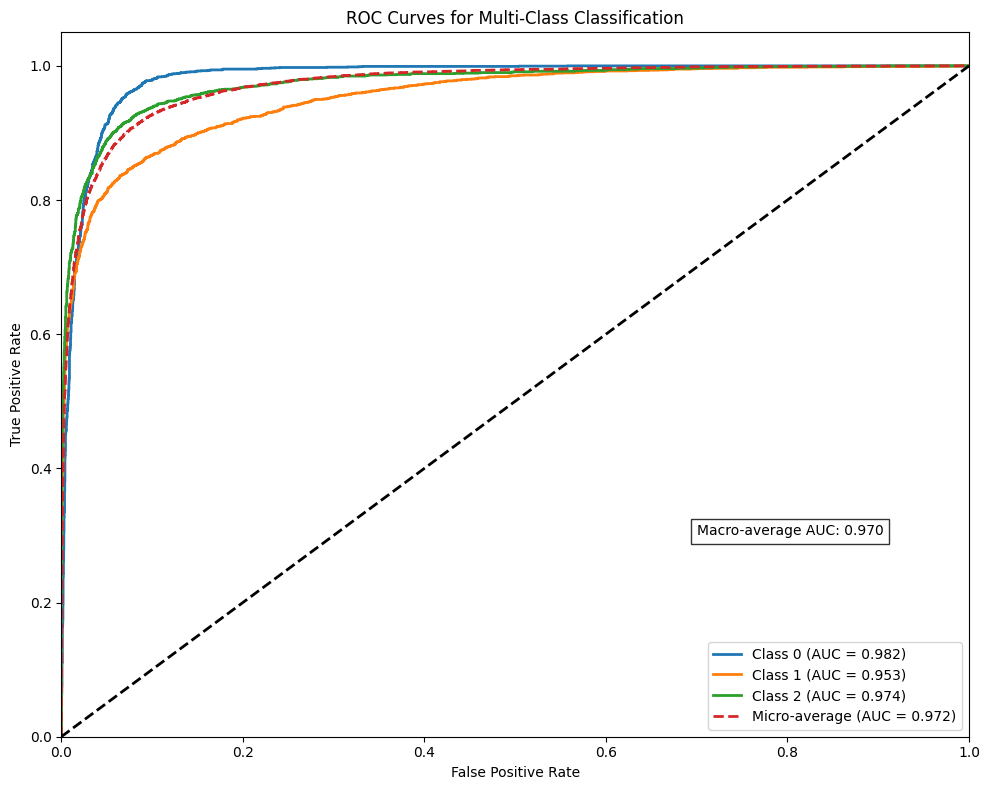


AUC Scores:
------------------------------
Class      | AUC Score 
------------------------------
0          | 0.9824
1          | 0.9532
2          | 0.9740
------------------------------
Micro-avg  | 0.9717
Macro-avg  | 0.9699
[0.9823507600000001, 0.9531964400000001, 0.974049] 0.9717135022222222 0.9698654000000001


In [15]:

# Now unfreeze the encoder and continue training with a lower learning rate
for param in classifier_model.encoder.parameters():
    param.requires_grad = True

print("Fine-tuning the entire model...")
classifier_model = train_classifier(classifier_model, train_loader_cls, val_loader_cls, num_epochs=50, device=device)


class_auc_scores, micro_auc, macro_auc = visualize_classifier_roc_auc(
    classifier_model, 
    val_loader_cls,
    num_classes=3, 
    device=device
)

print(class_auc_scores, micro_auc, macro_auc)

Starting AutoMAE training with learnable masking...


Epoch 1/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 29.44it/s]


[AutoMAE] Epoch [1/50], Recon Loss: 0.223861, Mask Loss: -0.022386, Total Loss: -0.022386, Mode: Mask Update


Epoch 2/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.44it/s]


[AutoMAE] Epoch [2/50], Recon Loss: 0.223902, Mask Loss: -0.022390, Total Loss: -0.022390, Mode: Mask Update


Epoch 3/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.10it/s]


[AutoMAE] Epoch [3/50], Recon Loss: 0.013161, Mask Loss: -0.001316, Total Loss: 0.013161, Mode: MAE Update


Epoch 4/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 29.92it/s]


[AutoMAE] Epoch [4/50], Recon Loss: 0.001326, Mask Loss: -0.000133, Total Loss: 0.001326, Mode: MAE Update


Epoch 5/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.54it/s]


[AutoMAE] Epoch [5/50], Recon Loss: 0.001090, Mask Loss: -0.000109, Total Loss: -0.000109, Mode: Mask Update


Epoch 6/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.51it/s]


[AutoMAE] Epoch [6/50], Recon Loss: 0.001102, Mask Loss: -0.000110, Total Loss: -0.000110, Mode: Mask Update


Epoch 7/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.34it/s]


[AutoMAE] Epoch [7/50], Recon Loss: 0.001036, Mask Loss: -0.000104, Total Loss: 0.001036, Mode: MAE Update


Epoch 8/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.19it/s]


[AutoMAE] Epoch [8/50], Recon Loss: 0.000884, Mask Loss: -0.000088, Total Loss: 0.000884, Mode: MAE Update


Epoch 9/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.38it/s]


[AutoMAE] Epoch [9/50], Recon Loss: 0.000864, Mask Loss: -0.000086, Total Loss: -0.000086, Mode: Mask Update


Epoch 10/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.11it/s]


[AutoMAE] Epoch [10/50], Recon Loss: 0.000850, Mask Loss: -0.000085, Total Loss: -0.000085, Mode: Mask Update


Epoch 11/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.09it/s]


[AutoMAE] Epoch [11/50], Recon Loss: 0.000823, Mask Loss: -0.000082, Total Loss: 0.000823, Mode: MAE Update


Epoch 12/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 29.96it/s]


[AutoMAE] Epoch [12/50], Recon Loss: 0.000759, Mask Loss: -0.000076, Total Loss: 0.000759, Mode: MAE Update


Epoch 13/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.43it/s]


[AutoMAE] Epoch [13/50], Recon Loss: 0.000705, Mask Loss: -0.000071, Total Loss: -0.000071, Mode: Mask Update


Epoch 14/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.40it/s]


[AutoMAE] Epoch [14/50], Recon Loss: 0.000700, Mask Loss: -0.000070, Total Loss: -0.000070, Mode: Mask Update


Epoch 15/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.36it/s]


[AutoMAE] Epoch [15/50], Recon Loss: 0.000710, Mask Loss: -0.000071, Total Loss: 0.000710, Mode: MAE Update


Epoch 16/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.04it/s]


[AutoMAE] Epoch [16/50], Recon Loss: 0.000683, Mask Loss: -0.000068, Total Loss: 0.000683, Mode: MAE Update


Epoch 17/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.22it/s]


[AutoMAE] Epoch [17/50], Recon Loss: 0.000627, Mask Loss: -0.000063, Total Loss: -0.000063, Mode: Mask Update


Epoch 18/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.41it/s]


[AutoMAE] Epoch [18/50], Recon Loss: 0.000627, Mask Loss: -0.000063, Total Loss: -0.000063, Mode: Mask Update


Epoch 19/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.15it/s]


[AutoMAE] Epoch [19/50], Recon Loss: 0.000649, Mask Loss: -0.000065, Total Loss: 0.000649, Mode: MAE Update


Epoch 20/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.26it/s]


[AutoMAE] Epoch [20/50], Recon Loss: 0.000629, Mask Loss: -0.000063, Total Loss: 0.000629, Mode: MAE Update


Epoch 21/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.39it/s]


[AutoMAE] Epoch [21/50], Recon Loss: 0.000784, Mask Loss: -0.000078, Total Loss: -0.000078, Mode: Mask Update


Epoch 22/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.39it/s]


[AutoMAE] Epoch [22/50], Recon Loss: 0.000783, Mask Loss: -0.000078, Total Loss: -0.000078, Mode: Mask Update


Epoch 23/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 29.75it/s]


[AutoMAE] Epoch [23/50], Recon Loss: 0.000634, Mask Loss: -0.000063, Total Loss: 0.000634, Mode: MAE Update


Epoch 24/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 29.95it/s]


[AutoMAE] Epoch [24/50], Recon Loss: 0.000597, Mask Loss: -0.000060, Total Loss: 0.000597, Mode: MAE Update


Epoch 25/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.33it/s]


[AutoMAE] Epoch [25/50], Recon Loss: 0.000612, Mask Loss: -0.000061, Total Loss: -0.000061, Mode: Mask Update


Epoch 26/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.52it/s]


[AutoMAE] Epoch [26/50], Recon Loss: 0.000616, Mask Loss: -0.000062, Total Loss: -0.000062, Mode: Mask Update


Epoch 27/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.05it/s]


[AutoMAE] Epoch [27/50], Recon Loss: 0.000563, Mask Loss: -0.000056, Total Loss: 0.000563, Mode: MAE Update


Epoch 28/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.29it/s]


[AutoMAE] Epoch [28/50], Recon Loss: 0.000575, Mask Loss: -0.000057, Total Loss: 0.000575, Mode: MAE Update


Epoch 29/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.21it/s]


[AutoMAE] Epoch [29/50], Recon Loss: 0.000672, Mask Loss: -0.000067, Total Loss: -0.000067, Mode: Mask Update


Epoch 30/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.49it/s]


[AutoMAE] Epoch [30/50], Recon Loss: 0.000667, Mask Loss: -0.000067, Total Loss: -0.000067, Mode: Mask Update


Epoch 31/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.24it/s]


[AutoMAE] Epoch [31/50], Recon Loss: 0.000561, Mask Loss: -0.000056, Total Loss: 0.000561, Mode: MAE Update


Epoch 32/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.12it/s]


[AutoMAE] Epoch [32/50], Recon Loss: 0.000543, Mask Loss: -0.000054, Total Loss: 0.000543, Mode: MAE Update


Epoch 33/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.40it/s]


[AutoMAE] Epoch [33/50], Recon Loss: 0.000555, Mask Loss: -0.000056, Total Loss: -0.000056, Mode: Mask Update


Epoch 34/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.41it/s]


[AutoMAE] Epoch [34/50], Recon Loss: 0.000559, Mask Loss: -0.000056, Total Loss: -0.000056, Mode: Mask Update


Epoch 35/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 29.79it/s]


[AutoMAE] Epoch [35/50], Recon Loss: 0.000549, Mask Loss: -0.000055, Total Loss: 0.000549, Mode: MAE Update


Epoch 36/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.08it/s]


[AutoMAE] Epoch [36/50], Recon Loss: 0.000530, Mask Loss: -0.000053, Total Loss: 0.000530, Mode: MAE Update


Epoch 37/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.45it/s]


[AutoMAE] Epoch [37/50], Recon Loss: 0.000519, Mask Loss: -0.000052, Total Loss: -0.000052, Mode: Mask Update


Epoch 38/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.60it/s]


[AutoMAE] Epoch [38/50], Recon Loss: 0.000526, Mask Loss: -0.000053, Total Loss: -0.000053, Mode: Mask Update


Epoch 39/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.23it/s]


[AutoMAE] Epoch [39/50], Recon Loss: 0.000535, Mask Loss: -0.000053, Total Loss: 0.000535, Mode: MAE Update


Epoch 40/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.35it/s]


[AutoMAE] Epoch [40/50], Recon Loss: 0.000546, Mask Loss: -0.000055, Total Loss: 0.000546, Mode: MAE Update


Epoch 41/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.17it/s]


[AutoMAE] Epoch [41/50], Recon Loss: 0.000507, Mask Loss: -0.000051, Total Loss: -0.000051, Mode: Mask Update


Epoch 42/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.41it/s]


[AutoMAE] Epoch [42/50], Recon Loss: 0.000492, Mask Loss: -0.000049, Total Loss: -0.000049, Mode: Mask Update


Epoch 43/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.23it/s]


[AutoMAE] Epoch [43/50], Recon Loss: 0.000522, Mask Loss: -0.000052, Total Loss: 0.000522, Mode: MAE Update


Epoch 44/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.24it/s]


[AutoMAE] Epoch [44/50], Recon Loss: 0.000509, Mask Loss: -0.000051, Total Loss: 0.000509, Mode: MAE Update


Epoch 45/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.54it/s]


[AutoMAE] Epoch [45/50], Recon Loss: 0.000515, Mask Loss: -0.000051, Total Loss: -0.000051, Mode: Mask Update


Epoch 46/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.48it/s]


[AutoMAE] Epoch [46/50], Recon Loss: 0.000518, Mask Loss: -0.000052, Total Loss: -0.000052, Mode: Mask Update


Epoch 47/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 29.96it/s]


[AutoMAE] Epoch [47/50], Recon Loss: 0.000531, Mask Loss: -0.000053, Total Loss: 0.000531, Mode: MAE Update


Epoch 48/50 - MAE Update: 100%|██████████| 157/157 [00:05<00:00, 30.11it/s]


[AutoMAE] Epoch [48/50], Recon Loss: 0.000509, Mask Loss: -0.000051, Total Loss: 0.000509, Mode: MAE Update


Epoch 49/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.54it/s]


[AutoMAE] Epoch [49/50], Recon Loss: 0.000497, Mask Loss: -0.000050, Total Loss: -0.000050, Mode: Mask Update


Epoch 50/50 - Mask Update: 100%|██████████| 157/157 [00:05<00:00, 30.49it/s]

[AutoMAE] Epoch [50/50], Recon Loss: 0.000490, Mask Loss: -0.000049, Total Loss: -0.000049, Mode: Mask Update


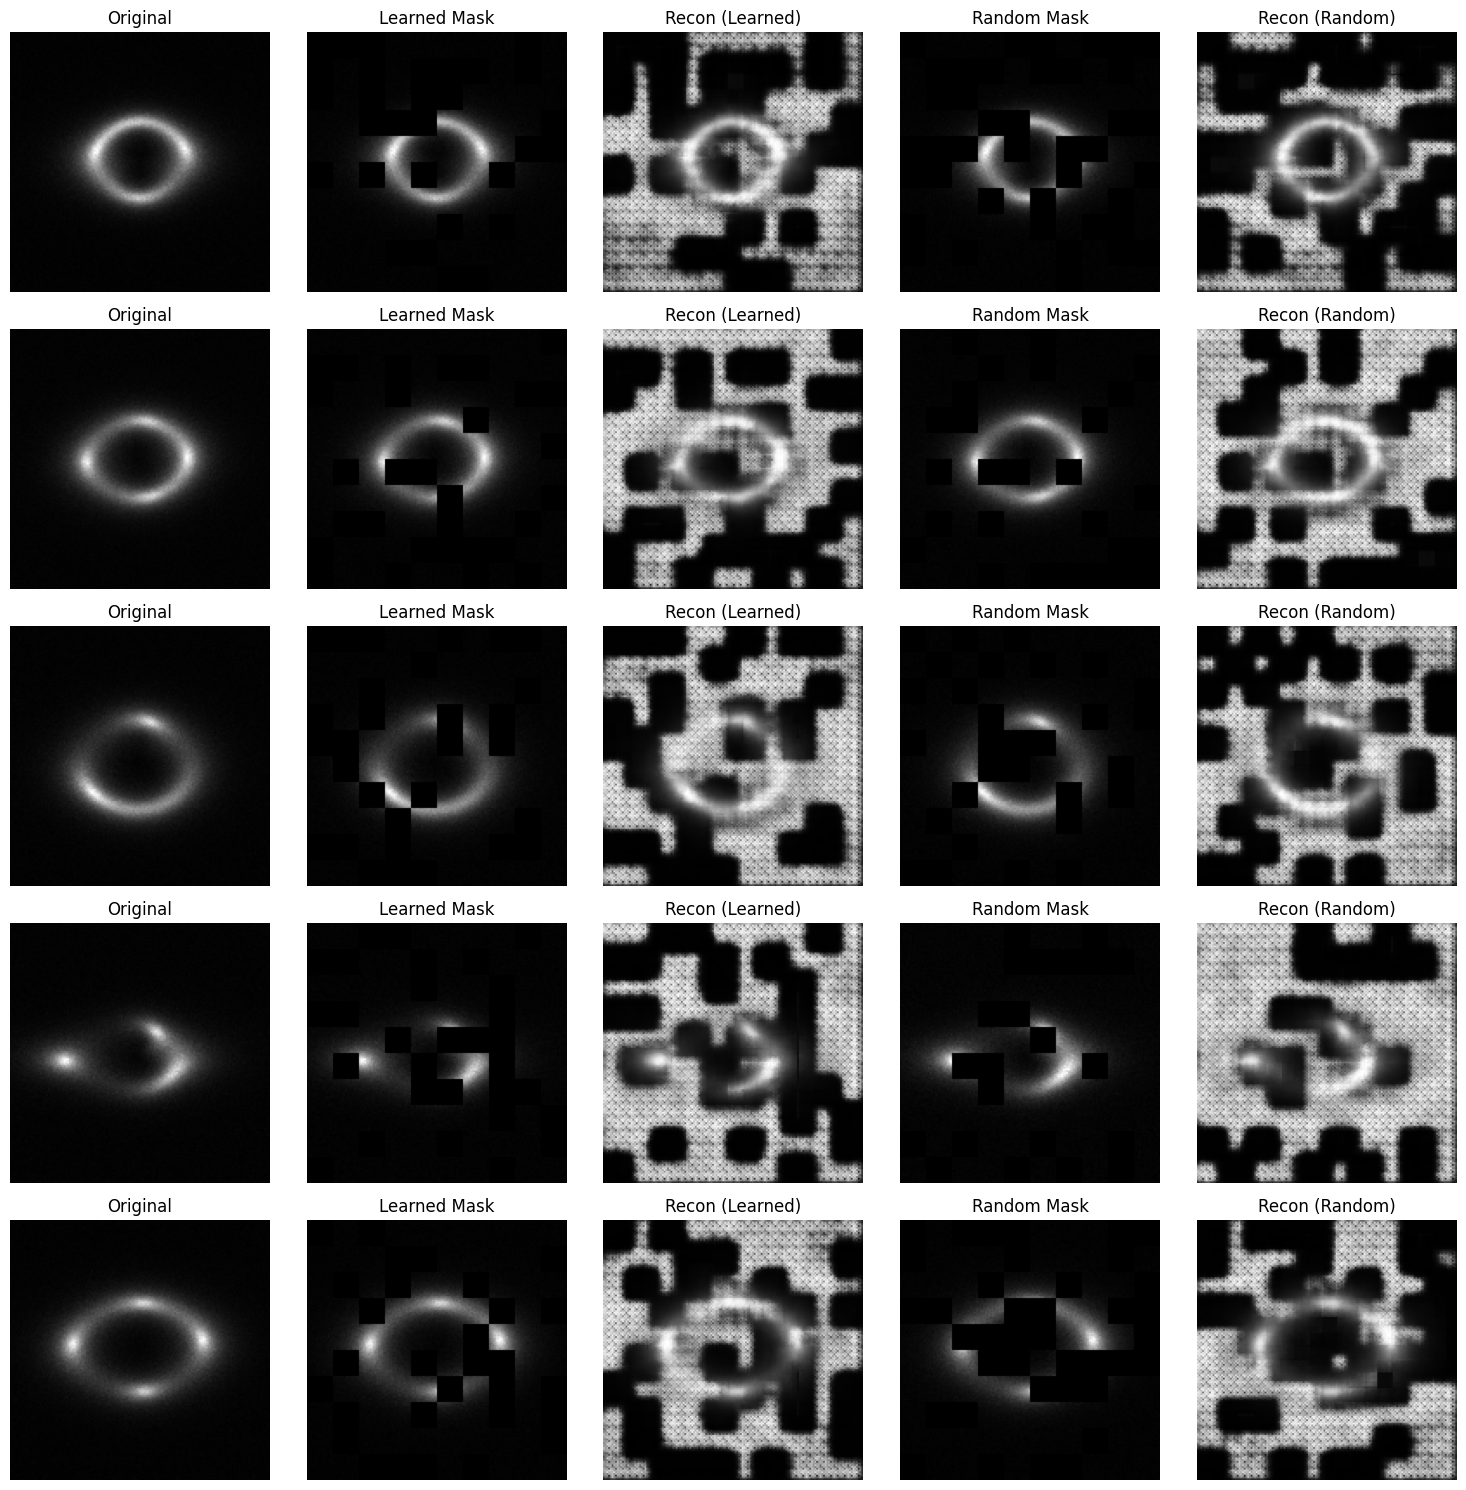

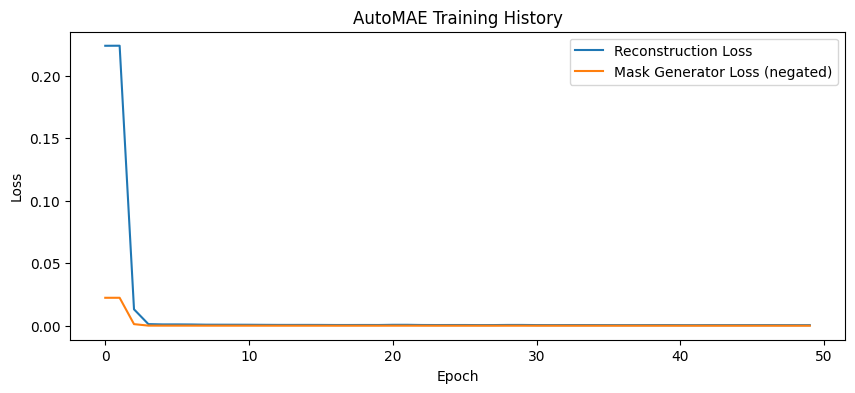

In [16]:
# Initialize the AutoMAE model with learnable masking
automae_model = MAE_LearnMask(in_channels=1, latent_dim=256, patch_size=15)

# Train the model with learnable masking
print("Starting AutoMAE training with learnable masking...")
automae_model = train_mae_learn(
    automae_model, 
    mae_loader, 
    num_epochs=50, 
    device=device, 
    mask_ratio=0.30, 
    patch_size=15,
    alpha=0.1,  # Weight for adversarial loss
    alternate_epochs=2  # Alternate between training modes every 2 epochs
)

# Get the pretrained encoder for downstream tasks
pretrained_encoder = automae_model.encoder

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting classifier fine-tuning with frozen encoder...


Epoch 1/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 48.81it/s]


[Classifier] Epoch [1/50], Train Loss: 1.1090, Train Acc: 34.08%, Val Loss: 1.1047, Val Acc: 34.03%, ROC AUC: 0.5120


Epoch 2/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.07it/s]


[Classifier] Epoch [2/50], Train Loss: 1.1029, Train Acc: 34.70%, Val Loss: 1.0996, Val Acc: 36.73%, ROC AUC: 0.5395


Epoch 3/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.11it/s]


[Classifier] Epoch [3/50], Train Loss: 1.0944, Train Acc: 37.09%, Val Loss: 1.0932, Val Acc: 37.80%, ROC AUC: 0.5536


Epoch 4/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 52.98it/s]


[Classifier] Epoch [4/50], Train Loss: 1.0840, Train Acc: 38.80%, Val Loss: 1.1457, Val Acc: 33.59%, ROC AUC: 0.5441


Epoch 5/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.86it/s]


[Classifier] Epoch [5/50], Train Loss: 1.0693, Train Acc: 40.59%, Val Loss: 1.2164, Val Acc: 33.97%, ROC AUC: 0.5508


Epoch 6/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 53.64it/s]


[Classifier] Epoch [6/50], Train Loss: 1.0505, Train Acc: 43.06%, Val Loss: 1.1150, Val Acc: 40.51%, ROC AUC: 0.6134


Epoch 7/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 43.11it/s]


[Classifier] Epoch [7/50], Train Loss: 1.0283, Train Acc: 45.52%, Val Loss: 1.9447, Val Acc: 33.37%, ROC AUC: 0.5596


Epoch 8/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.08it/s]


[Classifier] Epoch [8/50], Train Loss: 1.0109, Train Acc: 46.77%, Val Loss: 1.0234, Val Acc: 45.23%, ROC AUC: 0.6475


Epoch 9/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 52.81it/s]


[Classifier] Epoch [9/50], Train Loss: 0.9930, Train Acc: 48.17%, Val Loss: 1.0439, Val Acc: 45.71%, ROC AUC: 0.6584


Epoch 10/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 52.58it/s]


[Classifier] Epoch [10/50], Train Loss: 0.9756, Train Acc: 49.68%, Val Loss: 1.6307, Val Acc: 33.37%, ROC AUC: 0.5801


Epoch 11/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 52.94it/s]


[Classifier] Epoch [11/50], Train Loss: 0.9685, Train Acc: 50.15%, Val Loss: 0.9697, Val Acc: 49.59%, ROC AUC: 0.6923


Epoch 12/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 49.64it/s]


[Classifier] Epoch [12/50], Train Loss: 0.9504, Train Acc: 51.50%, Val Loss: 1.6129, Val Acc: 33.37%, ROC AUC: 0.5737


Epoch 13/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.23it/s]


[Classifier] Epoch [13/50], Train Loss: 0.9433, Train Acc: 51.86%, Val Loss: 0.9774, Val Acc: 49.11%, ROC AUC: 0.6934


Epoch 14/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 52.04it/s]


[Classifier] Epoch [14/50], Train Loss: 0.9262, Train Acc: 53.03%, Val Loss: 1.5259, Val Acc: 38.00%, ROC AUC: 0.6424


Epoch 15/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.60it/s]


[Classifier] Epoch [15/50], Train Loss: 0.9180, Train Acc: 53.40%, Val Loss: 1.2158, Val Acc: 37.95%, ROC AUC: 0.6383


Epoch 16/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.47it/s]


[Classifier] Epoch [16/50], Train Loss: 0.9065, Train Acc: 54.53%, Val Loss: 1.2744, Val Acc: 37.56%, ROC AUC: 0.6501


Epoch 17/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 45.90it/s]


[Classifier] Epoch [17/50], Train Loss: 0.8945, Train Acc: 55.27%, Val Loss: 5.3107, Val Acc: 33.33%, ROC AUC: 0.6378


Epoch 18/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 49.76it/s]


[Classifier] Epoch [18/50], Train Loss: 0.8449, Train Acc: 58.00%, Val Loss: 1.1180, Val Acc: 44.00%, ROC AUC: 0.6685
Early stopping triggered after 18 epochs
Loaded best model with AUC: 0.6934


Generating predictions: 100%|██████████| 118/118 [00:02<00:00, 50.23it/s]


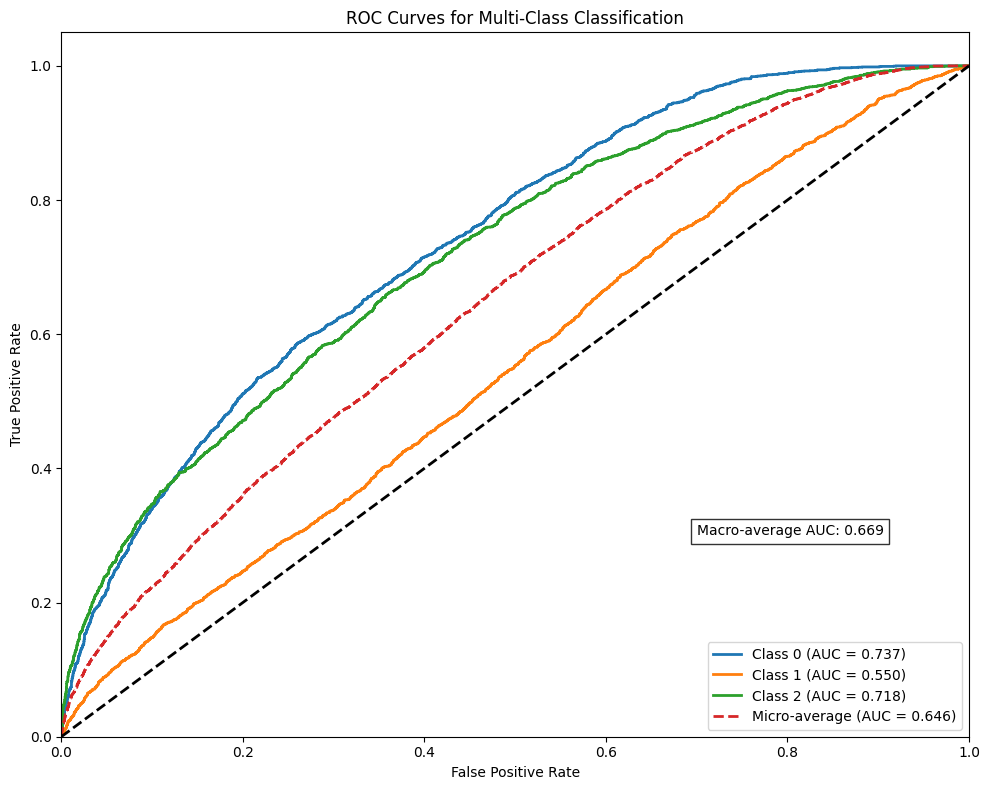

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



AUC Scores:
------------------------------
Class      | AUC Score 
------------------------------
0          | 0.7374
1          | 0.5498
2          | 0.7184
------------------------------
Micro-avg  | 0.6457
Macro-avg  | 0.6685
[0.7374181200000001, 0.54977816, 0.71836688] 0.6457476800000002 0.6685210533333334
Fine-tuning the entire model...


Epoch 1/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 47.17it/s]


[Classifier] Epoch [1/50], Train Loss: 0.9930, Train Acc: 48.61%, Val Loss: 1.9390, Val Acc: 33.33%, ROC AUC: 0.5522


Epoch 2/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 49.49it/s]


[Classifier] Epoch [2/50], Train Loss: 0.9369, Train Acc: 52.38%, Val Loss: 1.4976, Val Acc: 36.32%, ROC AUC: 0.6345


Epoch 3/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 46.35it/s]


[Classifier] Epoch [3/50], Train Loss: 0.8983, Train Acc: 54.99%, Val Loss: 1.1013, Val Acc: 46.23%, ROC AUC: 0.6821


Epoch 4/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 46.51it/s]


[Classifier] Epoch [4/50], Train Loss: 0.8463, Train Acc: 58.41%, Val Loss: 0.9097, Val Acc: 55.92%, ROC AUC: 0.7494


Epoch 5/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.96it/s]


[Classifier] Epoch [5/50], Train Loss: 0.8069, Train Acc: 61.15%, Val Loss: 3.8131, Val Acc: 33.77%, ROC AUC: 0.7107


Epoch 6/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 45.88it/s]


[Classifier] Epoch [6/50], Train Loss: 0.7467, Train Acc: 64.98%, Val Loss: 0.9056, Val Acc: 53.49%, ROC AUC: 0.7745


Epoch 7/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 49.17it/s]


[Classifier] Epoch [7/50], Train Loss: 0.7029, Train Acc: 67.63%, Val Loss: 2.0869, Val Acc: 42.12%, ROC AUC: 0.7602


Epoch 8/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.24it/s]


[Classifier] Epoch [8/50], Train Loss: 0.6625, Train Acc: 70.17%, Val Loss: 3.3045, Val Acc: 39.76%, ROC AUC: 0.7649


Epoch 9/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 53.03it/s]


[Classifier] Epoch [9/50], Train Loss: 0.6251, Train Acc: 72.28%, Val Loss: 3.1073, Val Acc: 34.41%, ROC AUC: 0.7022


Epoch 10/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.49it/s]


[Classifier] Epoch [10/50], Train Loss: 0.5937, Train Acc: 73.92%, Val Loss: 1.6294, Val Acc: 46.80%, ROC AUC: 0.7778


Epoch 11/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.98it/s]


[Classifier] Epoch [11/50], Train Loss: 0.5546, Train Acc: 76.20%, Val Loss: 1.6319, Val Acc: 46.81%, ROC AUC: 0.8216


Epoch 12/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 52.61it/s]


[Classifier] Epoch [12/50], Train Loss: 0.5257, Train Acc: 77.98%, Val Loss: 1.0221, Val Acc: 58.65%, ROC AUC: 0.8704


Epoch 13/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.79it/s]


[Classifier] Epoch [13/50], Train Loss: 0.4862, Train Acc: 79.76%, Val Loss: 0.7161, Val Acc: 67.92%, ROC AUC: 0.8744


Epoch 14/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.41it/s]


[Classifier] Epoch [14/50], Train Loss: 0.4617, Train Acc: 80.95%, Val Loss: 0.9539, Val Acc: 65.88%, ROC AUC: 0.8974


Epoch 15/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.61it/s]


[Classifier] Epoch [15/50], Train Loss: 0.4362, Train Acc: 82.10%, Val Loss: 1.0436, Val Acc: 57.44%, ROC AUC: 0.8714


Epoch 16/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.74it/s]


[Classifier] Epoch [16/50], Train Loss: 0.4092, Train Acc: 83.26%, Val Loss: 0.4998, Val Acc: 79.72%, ROC AUC: 0.9321


Epoch 17/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.17it/s]


[Classifier] Epoch [17/50], Train Loss: 0.3895, Train Acc: 84.42%, Val Loss: 0.7955, Val Acc: 65.91%, ROC AUC: 0.8644


Epoch 18/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.43it/s]


[Classifier] Epoch [18/50], Train Loss: 0.3664, Train Acc: 85.57%, Val Loss: 1.1714, Val Acc: 67.27%, ROC AUC: 0.8811


Epoch 19/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 51.96it/s]


[Classifier] Epoch [19/50], Train Loss: 0.3568, Train Acc: 86.05%, Val Loss: 1.5503, Val Acc: 60.96%, ROC AUC: 0.9030


Epoch 20/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.96it/s]


[Classifier] Epoch [20/50], Train Loss: 0.3325, Train Acc: 87.09%, Val Loss: 1.5913, Val Acc: 59.15%, ROC AUC: 0.8655


Epoch 21/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 50.86it/s]


[Classifier] Epoch [21/50], Train Loss: 0.2453, Train Acc: 90.67%, Val Loss: 1.5103, Val Acc: 52.24%, ROC AUC: 0.8986
Early stopping triggered after 21 epochs
Loaded best model with AUC: 0.9321


Generating predictions: 100%|██████████| 118/118 [00:02<00:00, 50.67it/s]


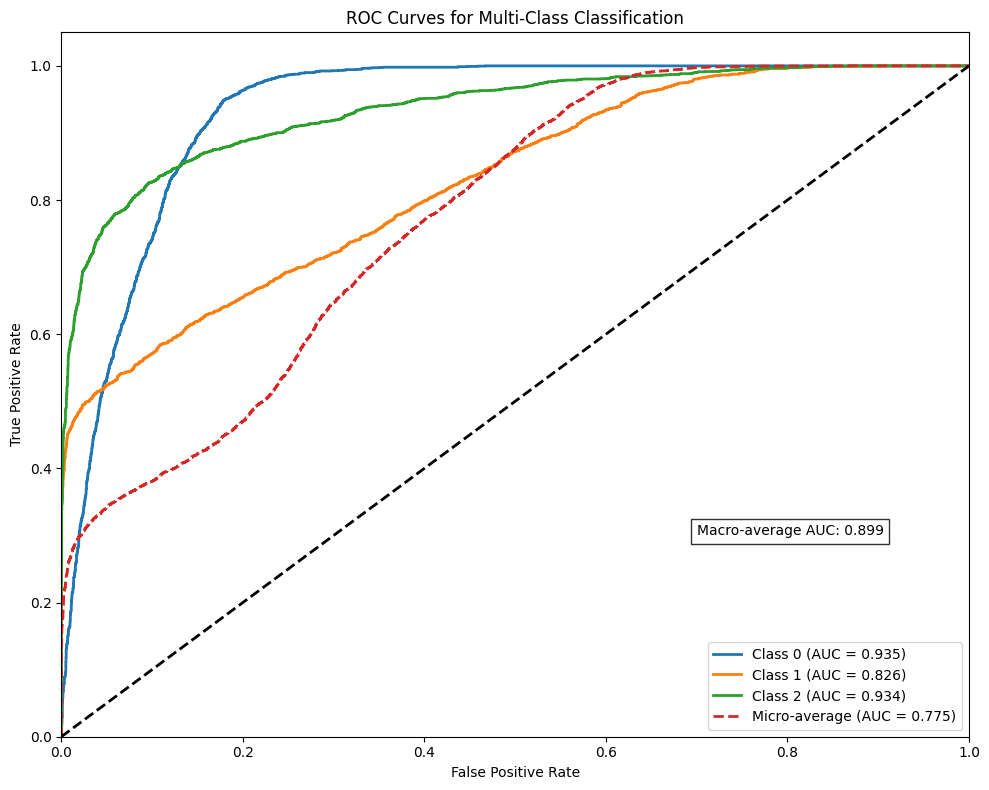


AUC Scores:
------------------------------
Class      | AUC Score 
------------------------------
0          | 0.9350
1          | 0.8264
2          | 0.9345
------------------------------
Micro-avg  | 0.7753
Macro-avg  | 0.8986
[0.9349644799999999, 0.8264355999999999, 0.9344732399999999] 0.7752719244444444 0.8986244399999999


In [17]:

# 6A task

# Full dataset paths for training and validation
train_dir = '/kaggle/input/deeplense-lensing-classes/dataset/train'
val_dir   = '/kaggle/input/deeplense-lensing-classes/dataset/val'
dataset_train = NpyImageDataset(train_dir, transform=transform)
dataset_val   = NpyImageDataset(val_dir, transform=transform)
train_loader_cls = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=4)
val_loader_cls   = DataLoader(dataset_val, batch_size=64, shuffle=False, num_workers=4)

# Build improved classification model using the pretrained encoder
classifier_model = ClassificationModel(encoder=pretrained_encoder, latent_dim=256, num_classes=3)

# Freeze the encoder for a few epochs to allow the new layers to adapt
for param in classifier_model.encoder.parameters():
    param.requires_grad = False

print("Starting classifier fine-tuning with frozen encoder...")
classifier_model = train_classifier(classifier_model, train_loader_cls, val_loader_cls, num_epochs=50, device=device)

class_auc_scores, micro_auc, macro_auc = visualize_classifier_roc_auc(
    classifier_model, 
    val_loader_cls,
    num_classes=3, 
    device=device
)

print(class_auc_scores, micro_auc, macro_auc)

# Now unfreeze the encoder and continue training with a lower learning rate
for param in classifier_model.encoder.parameters():
    param.requires_grad = True

print("Fine-tuning the entire model...")
classifier_model = train_classifier(classifier_model, train_loader_cls, val_loader_cls, num_epochs=50, device=device)


class_auc_scores, micro_auc, macro_auc = visualize_classifier_roc_auc(
    classifier_model, 
    val_loader_cls,
    num_classes=3, 
    device=device
)

print(class_auc_scores, micro_auc, macro_auc)


Starting super-resolution fine-tuning...


Epoch 1/50: 100%|██████████| 157/157 [00:33<00:00,  4.68it/s]


[Super-Resolution] Epoch [1/50], MSE Loss: 0.023456, L1 Loss: 0.114380, Total Loss: 0.080646, PSNR: 16.30 dB


Epoch 2/50: 100%|██████████| 157/157 [00:05<00:00, 26.43it/s]


[Super-Resolution] Epoch [2/50], MSE Loss: 0.000333, L1 Loss: 0.012979, Total Loss: 0.006822, PSNR: 34.78 dB


Epoch 3/50: 100%|██████████| 157/157 [00:05<00:00, 26.59it/s]


[Super-Resolution] Epoch [3/50], MSE Loss: 0.000139, L1 Loss: 0.006741, Total Loss: 0.003509, PSNR: 38.57 dB


Epoch 4/50: 100%|██████████| 157/157 [00:05<00:00, 26.54it/s]


[Super-Resolution] Epoch [4/50], MSE Loss: 0.000117, L1 Loss: 0.006271, Total Loss: 0.003252, PSNR: 39.32 dB


Epoch 5/50: 100%|██████████| 157/157 [00:06<00:00, 26.11it/s]


[Super-Resolution] Epoch [5/50], MSE Loss: 0.000111, L1 Loss: 0.006171, Total Loss: 0.003197, PSNR: 39.55 dB


Epoch 6/50: 100%|██████████| 157/157 [00:05<00:00, 26.32it/s]


[Super-Resolution] Epoch [6/50], MSE Loss: 0.000109, L1 Loss: 0.006143, Total Loss: 0.003180, PSNR: 39.63 dB


Epoch 7/50: 100%|██████████| 157/157 [00:05<00:00, 26.64it/s]


[Super-Resolution] Epoch [7/50], MSE Loss: 0.000106, L1 Loss: 0.006104, Total Loss: 0.003158, PSNR: 39.74 dB


Epoch 8/50: 100%|██████████| 157/157 [00:05<00:00, 26.84it/s]


[Super-Resolution] Epoch [8/50], MSE Loss: 0.000102, L1 Loss: 0.006033, Total Loss: 0.003119, PSNR: 39.89 dB


Epoch 9/50: 100%|██████████| 157/157 [00:05<00:00, 26.84it/s]


[Super-Resolution] Epoch [9/50], MSE Loss: 0.000102, L1 Loss: 0.006024, Total Loss: 0.003114, PSNR: 39.92 dB


Epoch 10/50: 100%|██████████| 157/157 [00:05<00:00, 26.41it/s]


[Super-Resolution] Epoch [10/50], MSE Loss: 0.000098, L1 Loss: 0.005959, Total Loss: 0.003077, PSNR: 40.08 dB


Epoch 11/50: 100%|██████████| 157/157 [00:05<00:00, 26.78it/s]


[Super-Resolution] Epoch [11/50], MSE Loss: 0.000098, L1 Loss: 0.005961, Total Loss: 0.003079, PSNR: 40.08 dB


Epoch 12/50: 100%|██████████| 157/157 [00:05<00:00, 26.54it/s]


[Super-Resolution] Epoch [12/50], MSE Loss: 0.000096, L1 Loss: 0.005930, Total Loss: 0.003061, PSNR: 40.16 dB


Epoch 13/50: 100%|██████████| 157/157 [00:05<00:00, 26.74it/s]


[Super-Resolution] Epoch [13/50], MSE Loss: 0.000096, L1 Loss: 0.005929, Total Loss: 0.003061, PSNR: 40.17 dB


Epoch 14/50: 100%|██████████| 157/157 [00:05<00:00, 26.74it/s]


[Super-Resolution] Epoch [14/50], MSE Loss: 0.000096, L1 Loss: 0.005917, Total Loss: 0.003054, PSNR: 40.20 dB


Epoch 15/50: 100%|██████████| 157/157 [00:05<00:00, 26.89it/s]


[Super-Resolution] Epoch [15/50], MSE Loss: 0.000095, L1 Loss: 0.005913, Total Loss: 0.003052, PSNR: 40.21 dB


Epoch 16/50: 100%|██████████| 157/157 [00:06<00:00, 25.75it/s]


[Super-Resolution] Epoch [16/50], MSE Loss: 0.000094, L1 Loss: 0.005886, Total Loss: 0.003037, PSNR: 40.27 dB


Epoch 17/50: 100%|██████████| 157/157 [00:06<00:00, 25.27it/s]


[Super-Resolution] Epoch [17/50], MSE Loss: 0.000095, L1 Loss: 0.005901, Total Loss: 0.003045, PSNR: 40.24 dB


Epoch 18/50: 100%|██████████| 157/157 [00:05<00:00, 26.17it/s]


[Super-Resolution] Epoch [18/50], MSE Loss: 0.000094, L1 Loss: 0.005894, Total Loss: 0.003041, PSNR: 40.26 dB


Epoch 19/50: 100%|██████████| 157/157 [00:06<00:00, 24.90it/s]


[Super-Resolution] Epoch [19/50], MSE Loss: 0.000094, L1 Loss: 0.005886, Total Loss: 0.003037, PSNR: 40.28 dB


Epoch 20/50: 100%|██████████| 157/157 [00:05<00:00, 26.44it/s]


[Super-Resolution] Epoch [20/50], MSE Loss: 0.000094, L1 Loss: 0.005889, Total Loss: 0.003039, PSNR: 40.27 dB


Epoch 21/50: 100%|██████████| 157/157 [00:06<00:00, 25.82it/s]


[Super-Resolution] Epoch [21/50], MSE Loss: 0.000094, L1 Loss: 0.005880, Total Loss: 0.003034, PSNR: 40.29 dB


Epoch 22/50: 100%|██████████| 157/157 [00:05<00:00, 26.21it/s]


[Super-Resolution] Epoch [22/50], MSE Loss: 0.000094, L1 Loss: 0.005880, Total Loss: 0.003033, PSNR: 40.29 dB


Epoch 23/50: 100%|██████████| 157/157 [00:06<00:00, 26.15it/s]


[Super-Resolution] Epoch [23/50], MSE Loss: 0.000094, L1 Loss: 0.005883, Total Loss: 0.003035, PSNR: 40.28 dB


Epoch 24/50: 100%|██████████| 157/157 [00:05<00:00, 26.54it/s]


[Super-Resolution] Epoch [24/50], MSE Loss: 0.000093, L1 Loss: 0.005874, Total Loss: 0.003030, PSNR: 40.31 dB


Epoch 25/50: 100%|██████████| 157/157 [00:05<00:00, 26.54it/s]


[Super-Resolution] Epoch [25/50], MSE Loss: 0.000093, L1 Loss: 0.005877, Total Loss: 0.003032, PSNR: 40.30 dB


Epoch 26/50: 100%|██████████| 157/157 [00:06<00:00, 26.06it/s]


[Super-Resolution] Epoch [26/50], MSE Loss: 0.000093, L1 Loss: 0.005872, Total Loss: 0.003029, PSNR: 40.31 dB


Epoch 27/50: 100%|██████████| 157/157 [00:05<00:00, 26.62it/s]


[Super-Resolution] Epoch [27/50], MSE Loss: 0.000093, L1 Loss: 0.005879, Total Loss: 0.003033, PSNR: 40.30 dB


Epoch 28/50: 100%|██████████| 157/157 [00:05<00:00, 26.40it/s]


[Super-Resolution] Epoch [28/50], MSE Loss: 0.000093, L1 Loss: 0.005877, Total Loss: 0.003032, PSNR: 40.30 dB


Epoch 29/50: 100%|██████████| 157/157 [00:05<00:00, 26.54it/s]


[Super-Resolution] Epoch [29/50], MSE Loss: 0.000093, L1 Loss: 0.005880, Total Loss: 0.003033, PSNR: 40.29 dB


Epoch 30/50: 100%|██████████| 157/157 [00:05<00:00, 26.47it/s]


[Super-Resolution] Epoch [30/50], MSE Loss: 0.000093, L1 Loss: 0.005872, Total Loss: 0.003029, PSNR: 40.31 dB


Epoch 31/50: 100%|██████████| 157/157 [00:05<00:00, 26.48it/s]


[Super-Resolution] Epoch [31/50], MSE Loss: 0.000093, L1 Loss: 0.005877, Total Loss: 0.003032, PSNR: 40.30 dB


Epoch 32/50: 100%|██████████| 157/157 [00:06<00:00, 26.15it/s]


[Super-Resolution] Epoch [32/50], MSE Loss: 0.000093, L1 Loss: 0.005875, Total Loss: 0.003031, PSNR: 40.31 dB


Epoch 33/50: 100%|██████████| 157/157 [00:05<00:00, 26.30it/s]


[Super-Resolution] Epoch [33/50], MSE Loss: 0.000093, L1 Loss: 0.005873, Total Loss: 0.003030, PSNR: 40.31 dB


Epoch 34/50: 100%|██████████| 157/157 [00:05<00:00, 26.44it/s]


[Super-Resolution] Epoch [34/50], MSE Loss: 0.000093, L1 Loss: 0.005871, Total Loss: 0.003028, PSNR: 40.32 dB


Epoch 35/50: 100%|██████████| 157/157 [00:05<00:00, 26.41it/s]


[Super-Resolution] Epoch [35/50], MSE Loss: 0.000093, L1 Loss: 0.005868, Total Loss: 0.003027, PSNR: 40.32 dB


Epoch 36/50: 100%|██████████| 157/157 [00:05<00:00, 26.36it/s]


[Super-Resolution] Epoch [36/50], MSE Loss: 0.000094, L1 Loss: 0.005883, Total Loss: 0.003035, PSNR: 40.29 dB


Epoch 37/50: 100%|██████████| 157/157 [00:06<00:00, 26.00it/s]


[Super-Resolution] Epoch [37/50], MSE Loss: 0.000094, L1 Loss: 0.005882, Total Loss: 0.003034, PSNR: 40.29 dB


Epoch 38/50: 100%|██████████| 157/157 [00:05<00:00, 26.26it/s]


[Super-Resolution] Epoch [38/50], MSE Loss: 0.000093, L1 Loss: 0.005872, Total Loss: 0.003029, PSNR: 40.31 dB


Epoch 39/50: 100%|██████████| 157/157 [00:06<00:00, 25.86it/s]


[Super-Resolution] Epoch [39/50], MSE Loss: 0.000093, L1 Loss: 0.005867, Total Loss: 0.003026, PSNR: 40.33 dB


Epoch 40/50: 100%|██████████| 157/157 [00:05<00:00, 26.23it/s]


[Super-Resolution] Epoch [40/50], MSE Loss: 0.000093, L1 Loss: 0.005876, Total Loss: 0.003031, PSNR: 40.30 dB


Epoch 41/50: 100%|██████████| 157/157 [00:05<00:00, 26.39it/s]


[Super-Resolution] Epoch [41/50], MSE Loss: 0.000093, L1 Loss: 0.005870, Total Loss: 0.003028, PSNR: 40.32 dB


Epoch 42/50: 100%|██████████| 157/157 [00:06<00:00, 25.98it/s]


[Super-Resolution] Epoch [42/50], MSE Loss: 0.000093, L1 Loss: 0.005874, Total Loss: 0.003030, PSNR: 40.31 dB


Epoch 43/50: 100%|██████████| 157/157 [00:05<00:00, 26.28it/s]


[Super-Resolution] Epoch [43/50], MSE Loss: 0.000093, L1 Loss: 0.005871, Total Loss: 0.003028, PSNR: 40.32 dB


Epoch 44/50: 100%|██████████| 157/157 [00:05<00:00, 26.36it/s]


[Super-Resolution] Epoch [44/50], MSE Loss: 0.000093, L1 Loss: 0.005872, Total Loss: 0.003029, PSNR: 40.31 dB


Epoch 45/50: 100%|██████████| 157/157 [00:05<00:00, 26.58it/s]


[Super-Resolution] Epoch [45/50], MSE Loss: 0.000093, L1 Loss: 0.005876, Total Loss: 0.003031, PSNR: 40.30 dB


Epoch 46/50: 100%|██████████| 157/157 [00:05<00:00, 26.65it/s]


[Super-Resolution] Epoch [46/50], MSE Loss: 0.000093, L1 Loss: 0.005876, Total Loss: 0.003031, PSNR: 40.30 dB


Epoch 47/50: 100%|██████████| 157/157 [00:05<00:00, 26.52it/s]


[Super-Resolution] Epoch [47/50], MSE Loss: 0.000093, L1 Loss: 0.005869, Total Loss: 0.003028, PSNR: 40.32 dB


Epoch 48/50: 100%|██████████| 157/157 [00:05<00:00, 26.26it/s]


[Super-Resolution] Epoch [48/50], MSE Loss: 0.000093, L1 Loss: 0.005875, Total Loss: 0.003030, PSNR: 40.31 dB


Epoch 49/50: 100%|██████████| 157/157 [00:05<00:00, 26.31it/s]


[Super-Resolution] Epoch [49/50], MSE Loss: 0.000093, L1 Loss: 0.005873, Total Loss: 0.003030, PSNR: 40.31 dB


Epoch 50/50: 100%|██████████| 157/157 [00:05<00:00, 26.50it/s]

[Super-Resolution] Epoch [50/50], MSE Loss: 0.000093, L1 Loss: 0.005871, Total Loss: 0.003028, PSNR: 40.32 dB


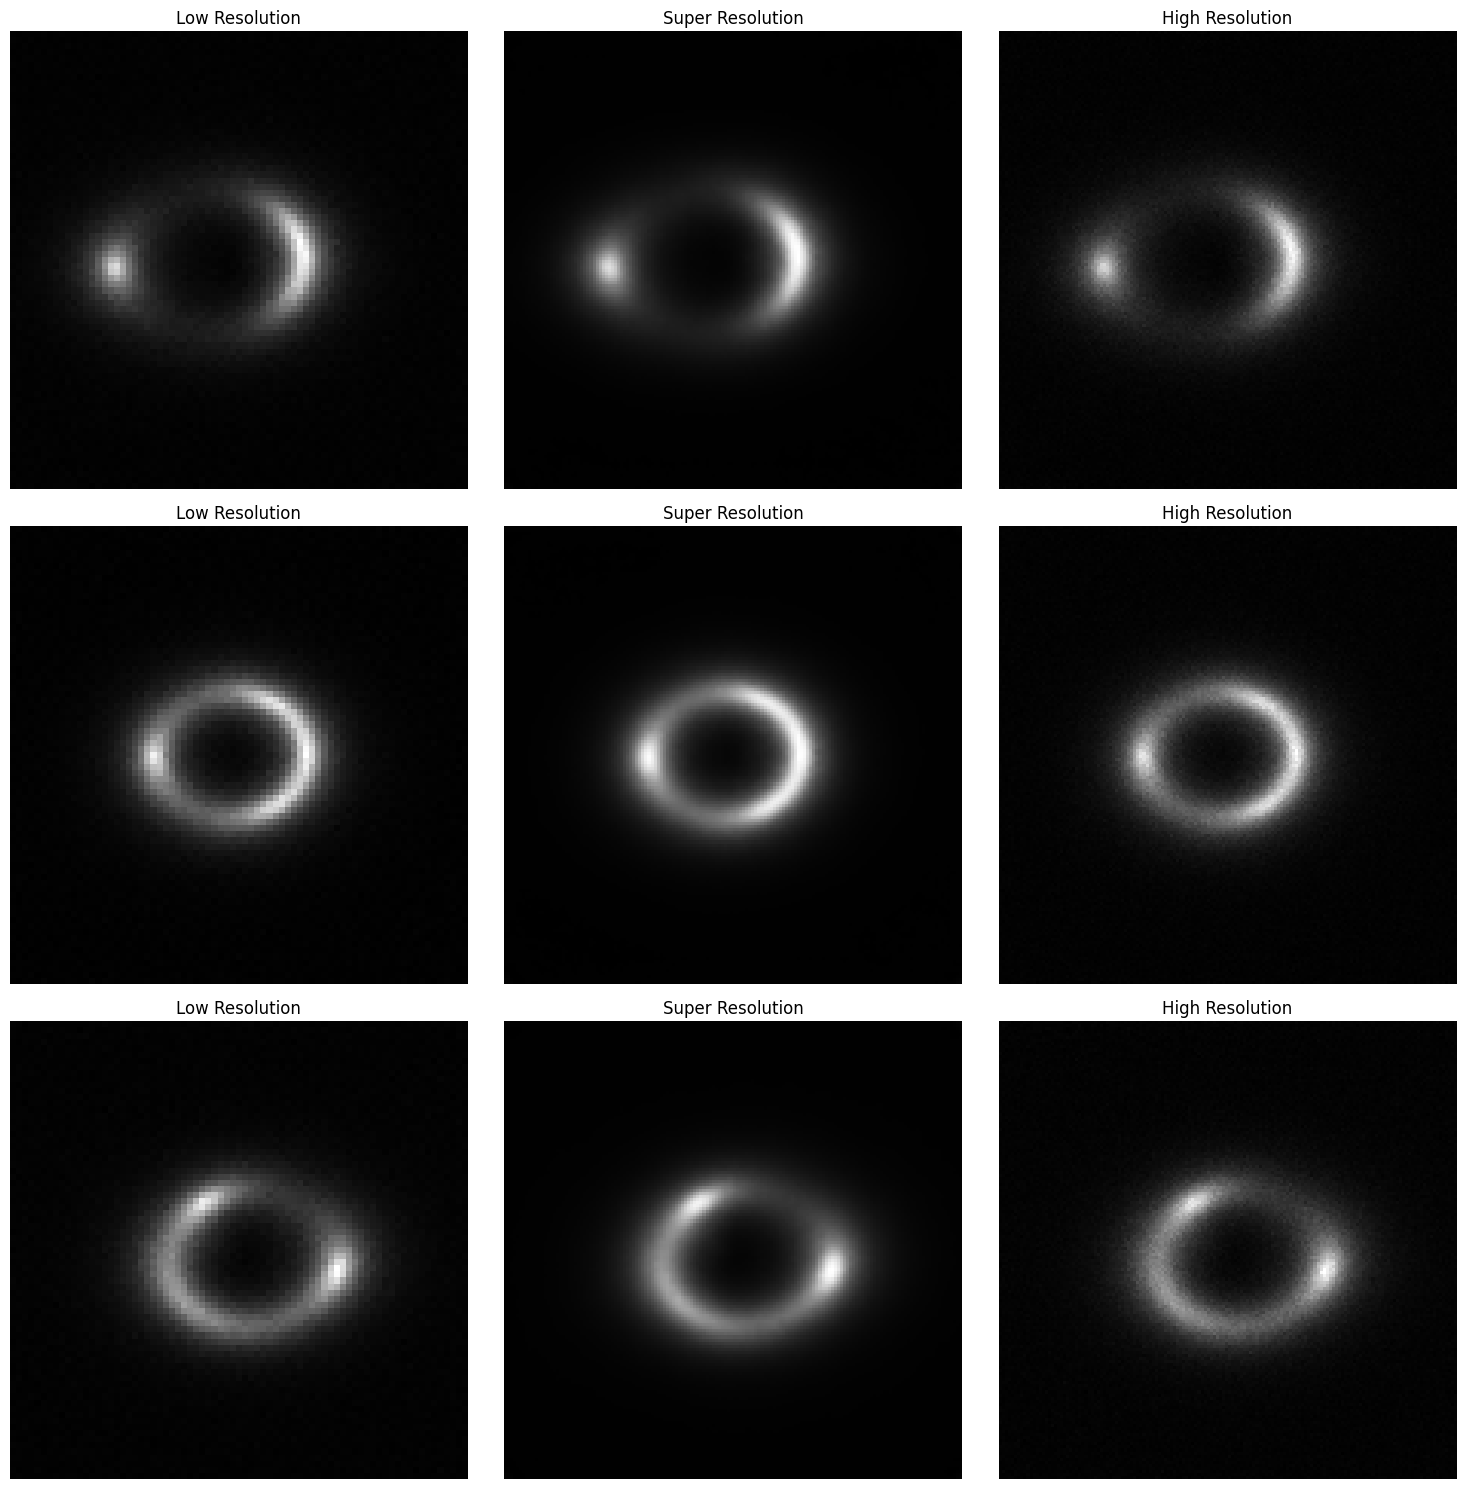

<Figure size 640x480 with 0 Axes>

In [18]:

## 6B task

# Directories for low-resolution (LR) and high-resolution (HR) images.
lr_dir = '/kaggle/input/deeplense-superres-dataset/Dataset/LR'
hr_dir = '/kaggle/input/deeplense-superres-dataset/Dataset/HR'
sr_dataset = NpySuperResolutionDataset(lr_dir, hr_dir, transform_lr=transform, transform_hr=transform)
sr_loader = DataLoader(sr_dataset, batch_size=64, shuffle=True, num_workers=4)

# Build improved super-resolution model using the pretrained encoder
sr_model = SuperResolutionModel(encoder=pretrained_encoder, latent_dim=256, in_channels=1)
print("Starting super-resolution fine-tuning...")
sr_model = train_super_resolution(sr_model, sr_loader, num_epochs=50, device=device)


In [19]:
  
#saving the final models
torch.save(mae_model.state_dict(), 'mae_model.pth')
torch.save(classifier_model.state_dict(), 'classifier_model.pth')
torch.save(sr_model.state_dict(), 'superres_model.pth')
torch.save(automae_model.state_dict(), 'automae_model.pth')

print("Training complete.")

Training complete.
